A model that generates images pixel by pixel
by predicting the likelihood of the next pixel based on the pixels before it. The model
is called PixelCNN, and it can be trained to generate images autoregressively.


a convolutional layer can be used to extract features from an
image by applying a series of filters. The output of the layer at a particular pixel is a
weighted sum of the filter weights multiplied by the preceding layer values over a
small square centered on the pixel. This method can detect edges and textures and, at
deeper layers, shapes and higher-level features.

Whilst convolutional layers are extremely useful for feature detection, they cannot
directly be used in an autoregressive sense, because there is no ordering placed on the
pixels. They rely on the fact that all pixels are treated equally—no pixel is treated as
the start or end of the image.

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [5]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

# Masking Convolution Layers

For us to be able to apply convolutional layers to image generation in an autoregres‐
sive sense, we must first place an ordering on the pixels and ensure that the filters are
only able to see pixels that precede the pixel in question. We can then generate images
one pixel at a time, by applying convolutional filters to the current image to predict
the value of the next pixel from all preceding pixels.

We first need to choose an ordering for the pixels—a sensible suggestion is to order
the pixels from top left to bottom right, moving first along the rows and then down
the columns.


We then mask the convolutional filters so that the output of the layer at each pixel is
only influenced by pixel values that precede the pixel in question. This is achieved by
multiplying a mask of ones and zeros with the filter weights matrix, so that the values
of any pixels that are after the target pixel are zeroed.

There are actually two different kinds of masks in a PixelCNN:

• Type A, where the value of the central pixel is masked

• Type B, where the value of the central pixel is not masked


The initial masked convolutional layer (i.e., the one that is applied directly to the
input image) cannot use the central pixel, because this is precisely the pixel we want
the network to guess! However, subsequent layers can use the central pixel because
this will have been calculated only as a result of information from preceding pixels in
the original input image.


In [6]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

Note that this simplified example assumes a grayscale image (i.e., with one channel).
If we have color images, we’ll have three color channels that we can also place an
ordering on so that, for example, the red channel precedes the blue channel, which
precedes the green channel.

A residual block is a set of layers where the output is added to the input before being
passed on to the rest of the network. In other words, the input has a fast-track route
to the output, without having to go through the intermediate layers—this is called a
skip connection. The rationale behind including a skip connection is that if the opti‐
mal transformation is just to keep the input the same, this can be achieved by simply
zeroing the weights of the intermediate layers. Without the skip connection, the net‐
work would have to find an identity mapping through the intermediate layers, which
is much harder.

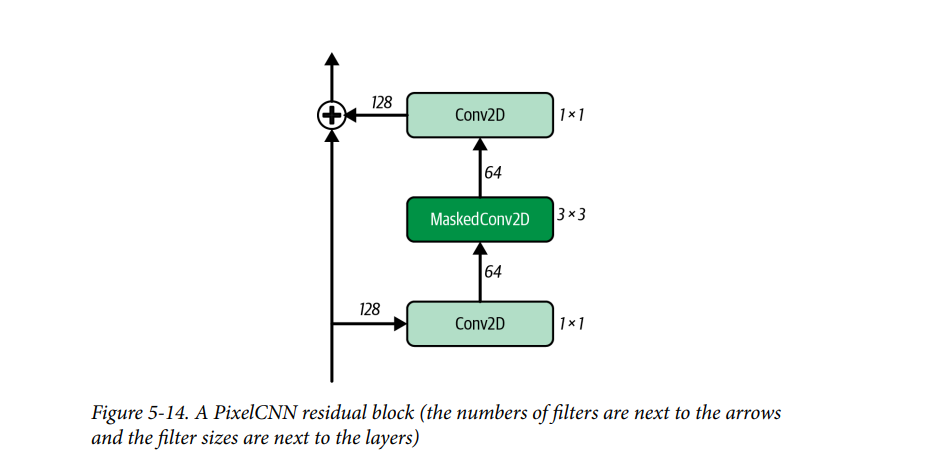

In [7]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

we put together the whole PixelCNN network, approximately fol
lowing the structure laid out in the original paper. In the original paper, the output
layer is a 256-filter Conv2D layer, with softmax activation. In other words, the network
tries to re-create its input by predicting the correct pixel values, a bit like an autoen
coder. The difference is that the PixelCNN is constrained so that no information from
earlier pixels can flow through to influence the prediction for each pixel, due to the
way that network is designed, using MaskedConv2D layers.


A challenge with this approach is that the network has no way to understand that a
pixel value of, say, 200 is very close to a pixel value of 201. It must learn every pixel
output value independently, which means training can be very slow, even for the sim
plest datasets. Therefore, in our implementation, we instead simplify the input so that
each pixel can take only one of four values. This way, we can use a 4-filter Conv2D
output layer instead of 256.


In [9]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d_8 (MaskedCon  (None, 16, 16, 128)       6400      
 v2D)                                                            
                                                                 
 residual_block_5 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_6 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_7 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                    

The model Input is a grayscale image of size 16 × 16 × 1, with inputs scaled
between 0 and 1.

The first Type A MaskedConv2D layer with a kernel size of 7 uses information
from 24 pixels—21 pixels in the three rows above the focus pixel and 3 to the left
(the focus pixel itself is not used).

Five ResidualBlock layer groups are stacked sequentially.

Two Type B MaskedConv2D layers with a kernel size of 1 act as Dense layers across
the number of channels for each pixel.

The final Conv2D layer reduces the number of channels to four—the number of
pixel levels for this example.

The Model is built to accept an image and output an image of the same
dimensions.


In [11]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [12]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)

        fig, axes = plt.subplots(1, self.num_img, figsize=(20, 4))
        for i, image in enumerate(generated_images):
            axes[i].imshow(image.squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Image {i+1}')
        plt.show()


img_generator_callback = ImageGenerator(num_img=10)

Start with a batch of empty images (all zeros).


Loop over the rows, columns, and channels of the current image, predicting the
distribution of the next pixel value.

Sample a pixel level from the predicted distribution (for our example, a level in
the range [0, 3]).


Convert the pixel level to the range [0, 1] and overwrite the pixel value in the current image, ready for the next iteration of the loop.

Epoch 1/150
469/469 [==============================] - ETA: 0s - loss: 0.4916

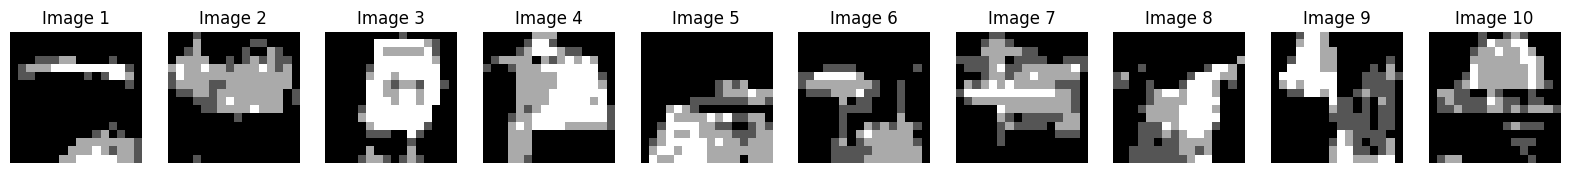

469/469 [==============================] - 44s 73ms/step - loss: 0.4916
Epoch 2/150
469/469 [==============================] - ETA: 0s - loss: 0.4026

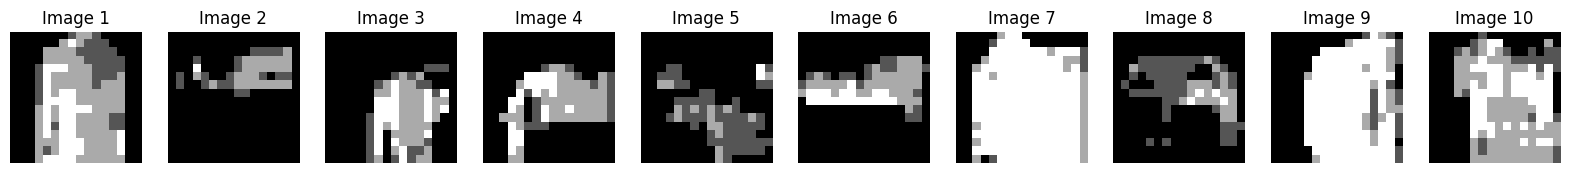

469/469 [==============================] - 31s 65ms/step - loss: 0.4026
Epoch 3/150
469/469 [==============================] - ETA: 0s - loss: 0.3892

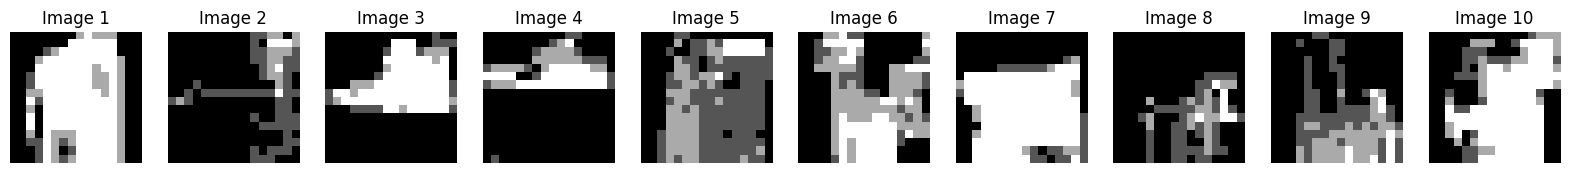

469/469 [==============================] - 31s 67ms/step - loss: 0.3892
Epoch 4/150
469/469 [==============================] - ETA: 0s - loss: 0.3821

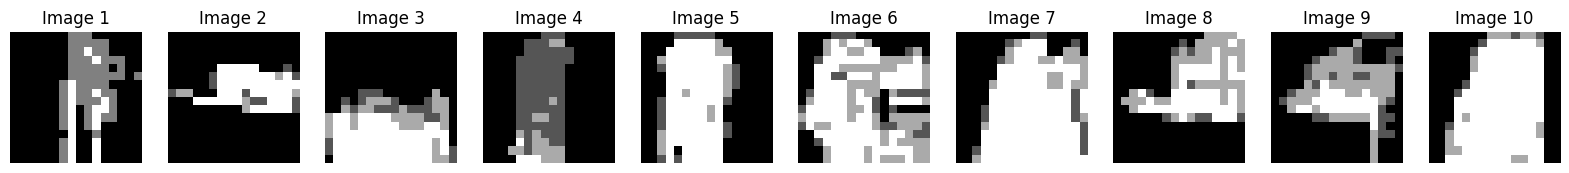

469/469 [==============================] - 32s 68ms/step - loss: 0.3821
Epoch 5/150
468/469 [============================>.] - ETA: 0s - loss: 0.3776

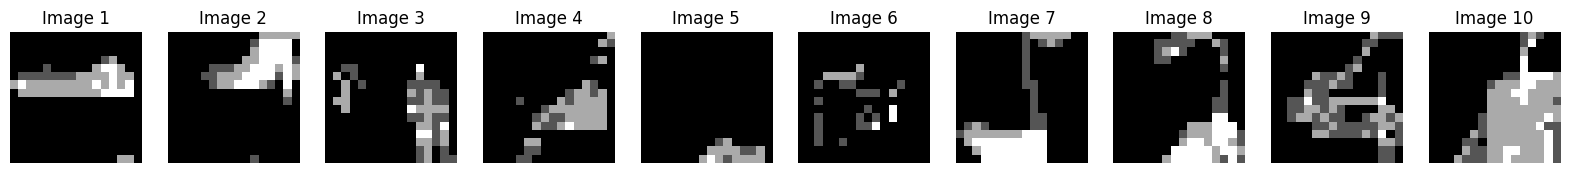

469/469 [==============================] - 31s 67ms/step - loss: 0.3776
Epoch 6/150
467/469 [============================>.] - ETA: 0s - loss: 0.3739

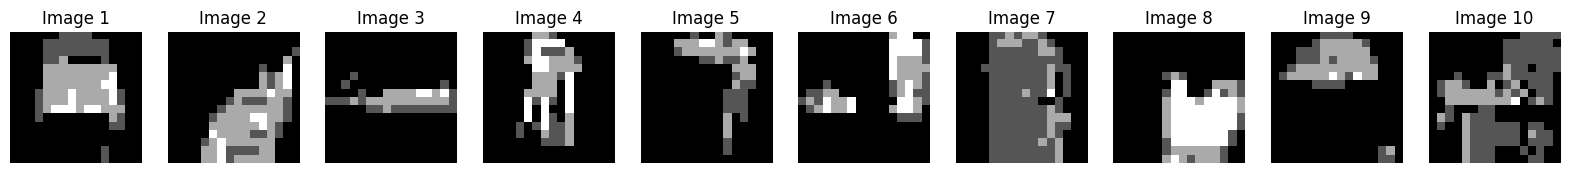

469/469 [==============================] - 31s 65ms/step - loss: 0.3739
Epoch 7/150
467/469 [============================>.] - ETA: 0s - loss: 0.3706

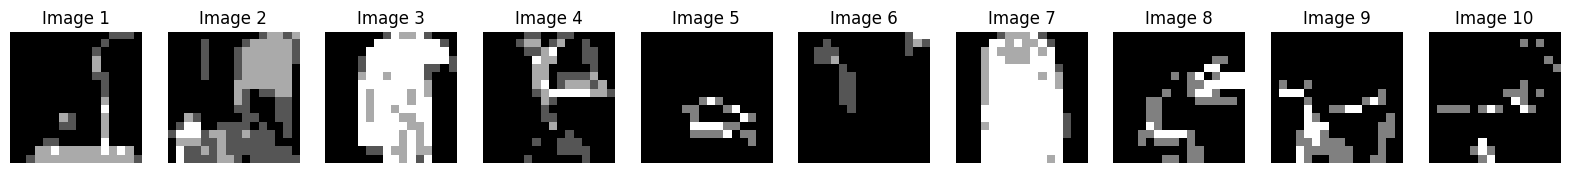

469/469 [==============================] - 30s 65ms/step - loss: 0.3706
Epoch 8/150
468/469 [============================>.] - ETA: 0s - loss: 0.3681

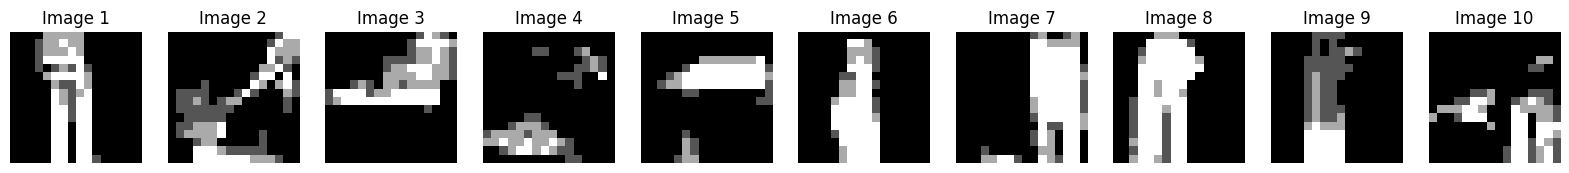

469/469 [==============================] - 33s 70ms/step - loss: 0.3681
Epoch 9/150
469/469 [==============================] - ETA: 0s - loss: 0.3654

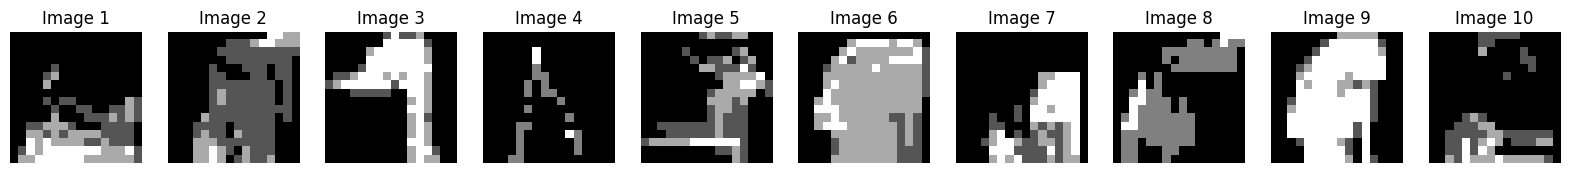

469/469 [==============================] - 31s 67ms/step - loss: 0.3654
Epoch 10/150
467/469 [============================>.] - ETA: 0s - loss: 0.3635

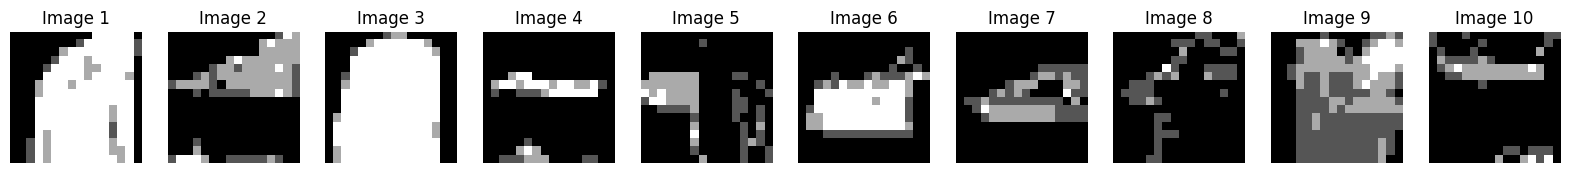

469/469 [==============================] - 31s 67ms/step - loss: 0.3634
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.3609

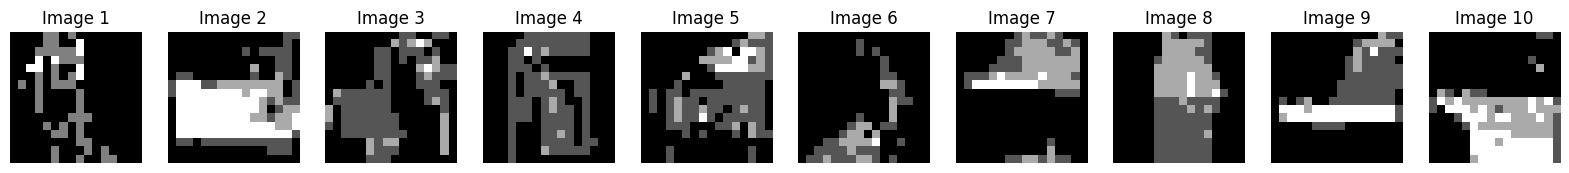

469/469 [==============================] - 31s 67ms/step - loss: 0.3609
Epoch 12/150
469/469 [==============================] - ETA: 0s - loss: 0.3590

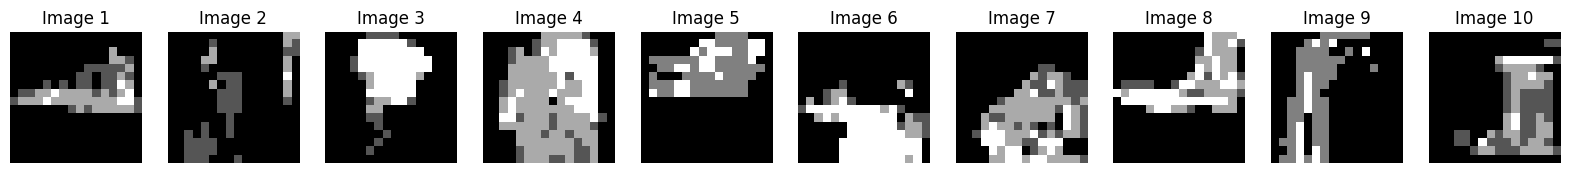

469/469 [==============================] - 31s 66ms/step - loss: 0.3590
Epoch 13/150
469/469 [==============================] - ETA: 0s - loss: 0.3574

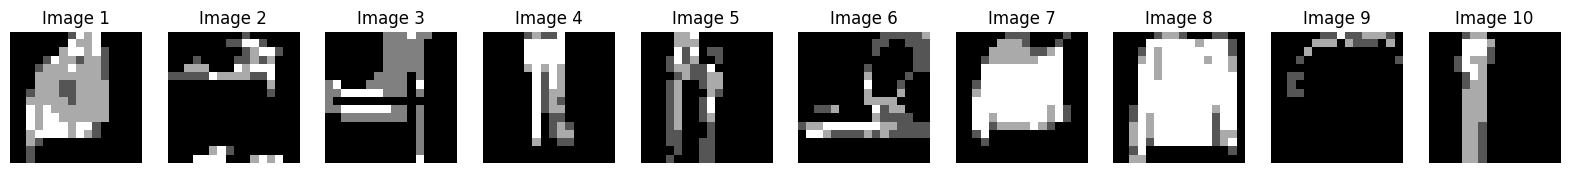

469/469 [==============================] - 31s 65ms/step - loss: 0.3574
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.3558

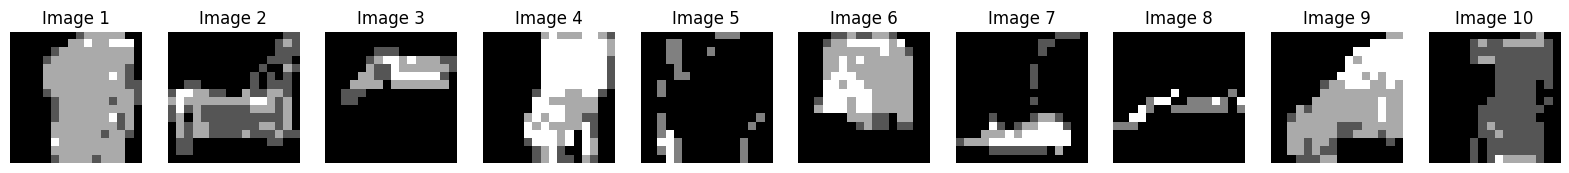

469/469 [==============================] - 31s 67ms/step - loss: 0.3558
Epoch 15/150
469/469 [==============================] - ETA: 0s - loss: 0.3545

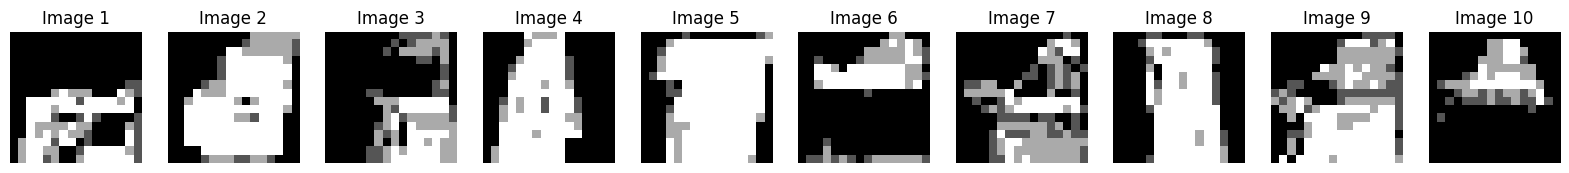

469/469 [==============================] - 31s 66ms/step - loss: 0.3545
Epoch 16/150
469/469 [==============================] - ETA: 0s - loss: 0.3534

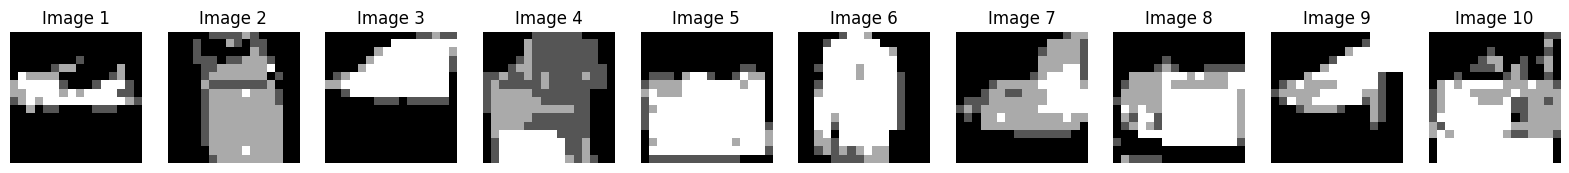

469/469 [==============================] - 30s 65ms/step - loss: 0.3534
Epoch 17/150
469/469 [==============================] - ETA: 0s - loss: 0.3522

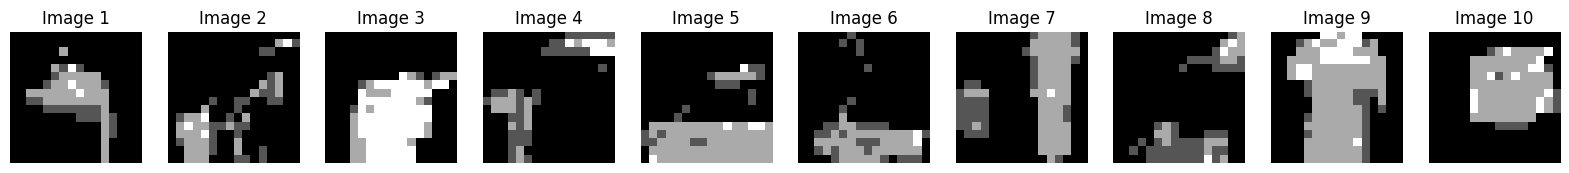

469/469 [==============================] - 32s 69ms/step - loss: 0.3522
Epoch 18/150
467/469 [============================>.] - ETA: 0s - loss: 0.3515

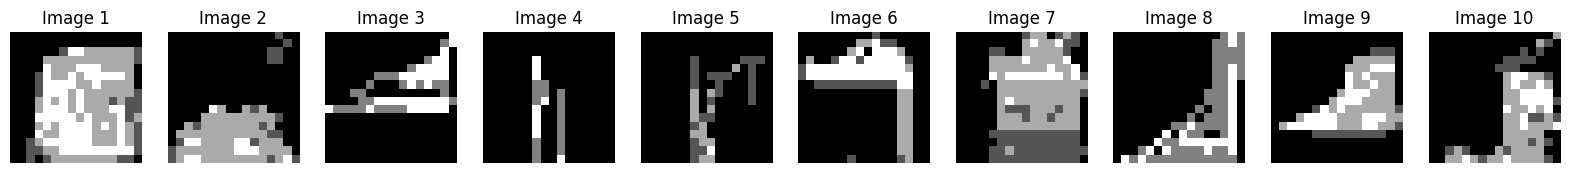

469/469 [==============================] - 30s 64ms/step - loss: 0.3514
Epoch 19/150
469/469 [==============================] - ETA: 0s - loss: 0.3504

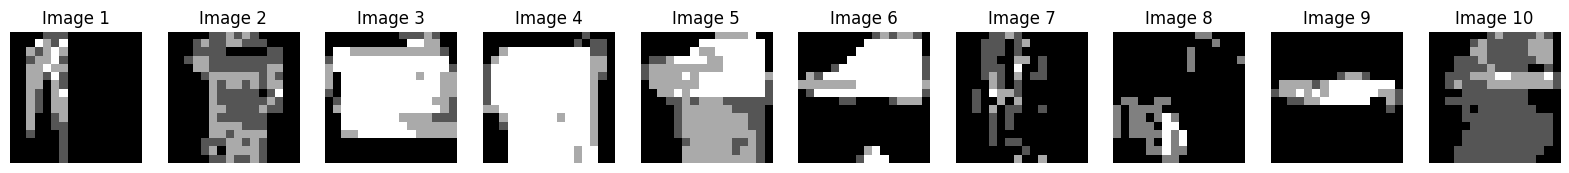

469/469 [==============================] - 32s 67ms/step - loss: 0.3504
Epoch 20/150
469/469 [==============================] - ETA: 0s - loss: 0.3495

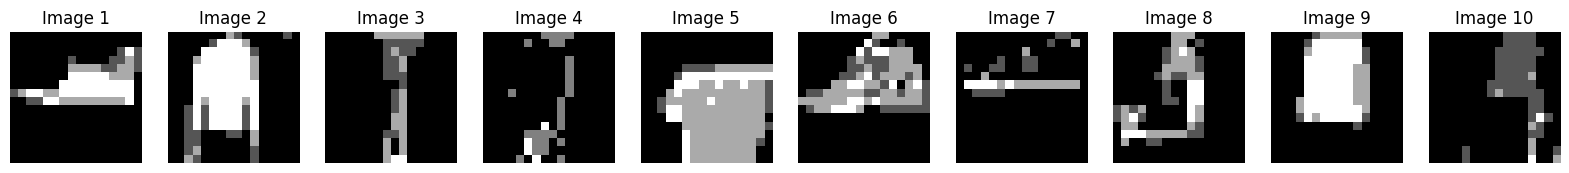

469/469 [==============================] - 31s 67ms/step - loss: 0.3495
Epoch 21/150
469/469 [==============================] - ETA: 0s - loss: 0.3487

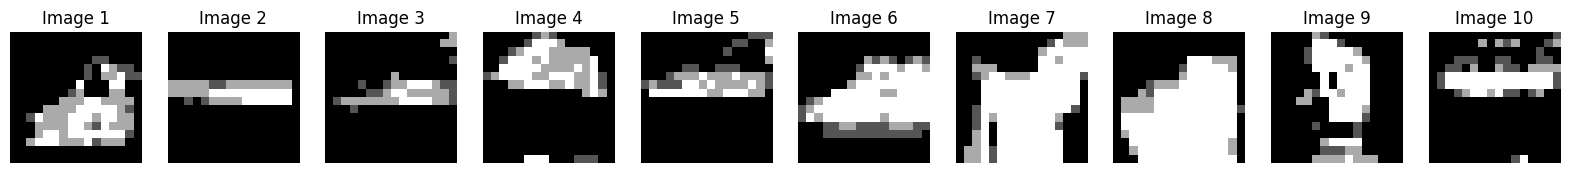

469/469 [==============================] - 31s 66ms/step - loss: 0.3487
Epoch 22/150
469/469 [==============================] - ETA: 0s - loss: 0.3478

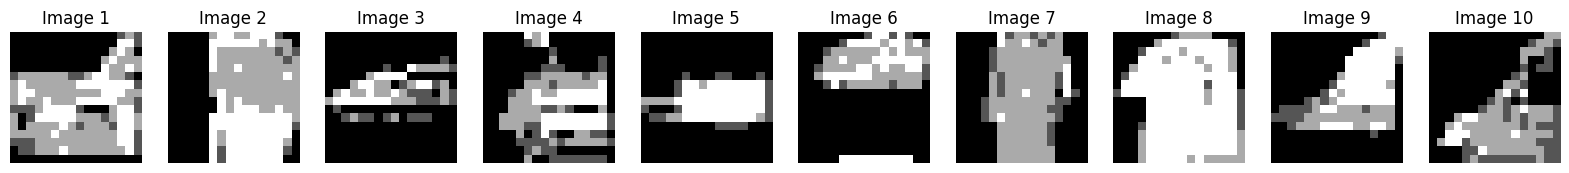

469/469 [==============================] - 31s 66ms/step - loss: 0.3478
Epoch 23/150
469/469 [==============================] - ETA: 0s - loss: 0.3469

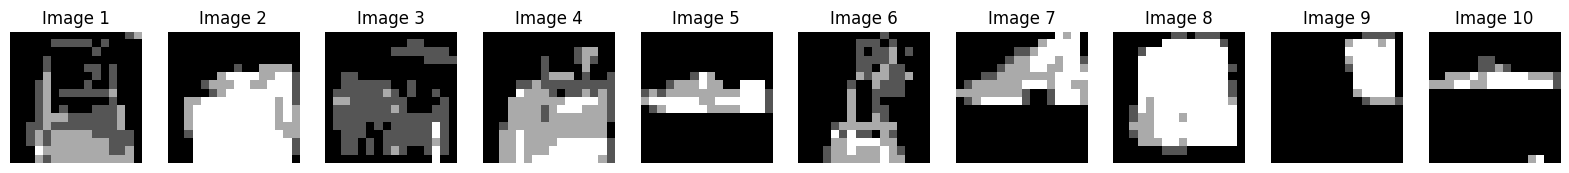

469/469 [==============================] - 30s 64ms/step - loss: 0.3469
Epoch 24/150
469/469 [==============================] - ETA: 0s - loss: 0.3464

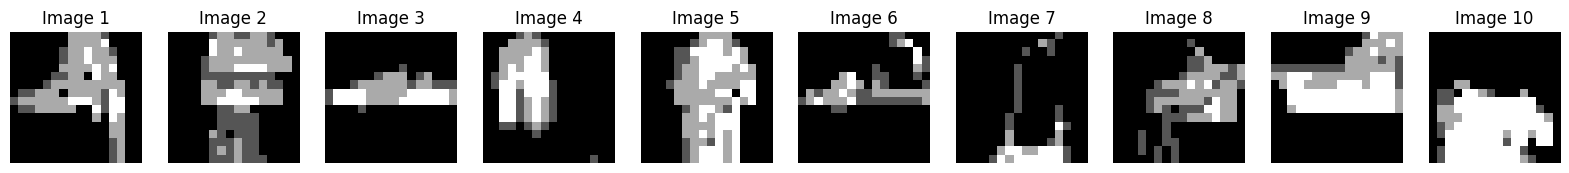

469/469 [==============================] - 32s 68ms/step - loss: 0.3464
Epoch 25/150
469/469 [==============================] - ETA: 0s - loss: 0.3458

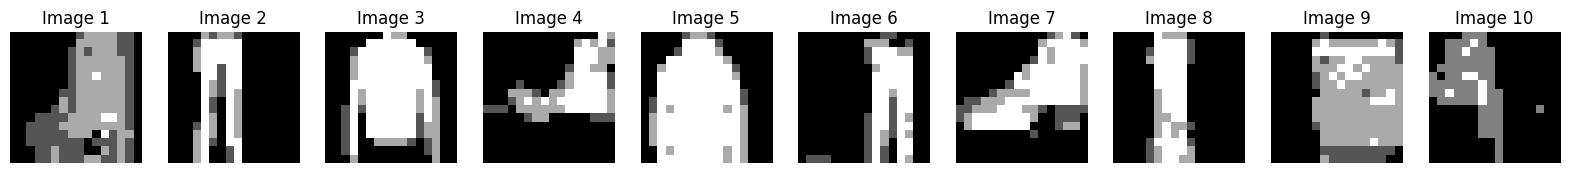

469/469 [==============================] - 32s 68ms/step - loss: 0.3458
Epoch 26/150
469/469 [==============================] - ETA: 0s - loss: 0.3450

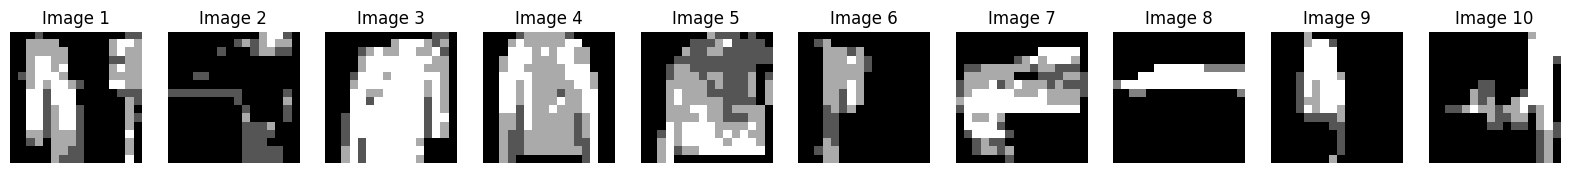

469/469 [==============================] - 31s 67ms/step - loss: 0.3450
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3446

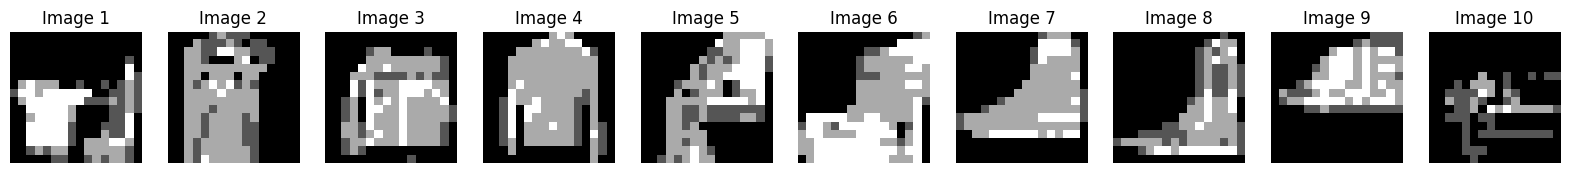

469/469 [==============================] - 31s 67ms/step - loss: 0.3446
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.3439

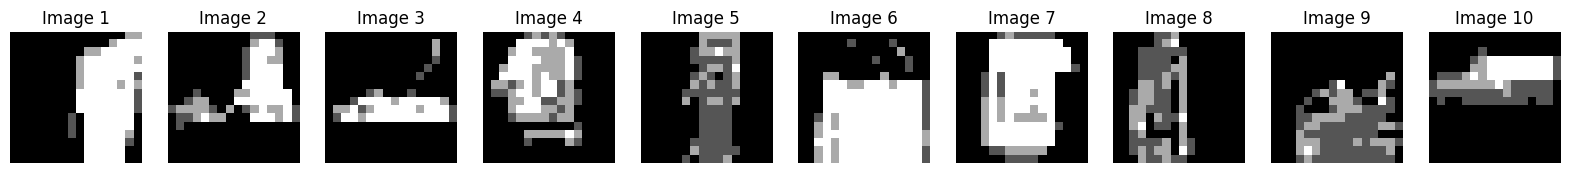

469/469 [==============================] - 32s 68ms/step - loss: 0.3439
Epoch 29/150
469/469 [==============================] - ETA: 0s - loss: 0.3434

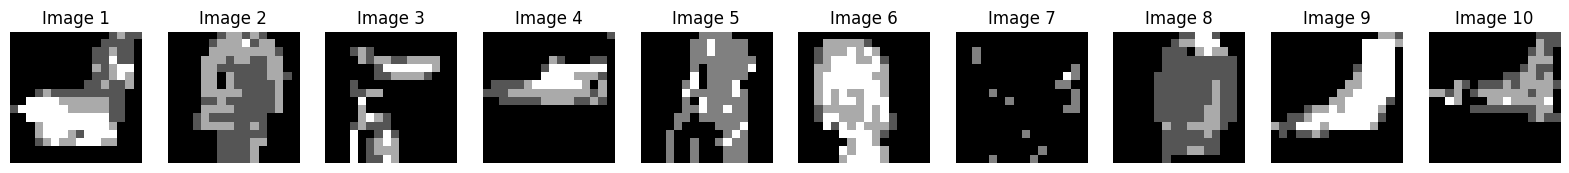

469/469 [==============================] - 32s 67ms/step - loss: 0.3434
Epoch 30/150
469/469 [==============================] - ETA: 0s - loss: 0.3429

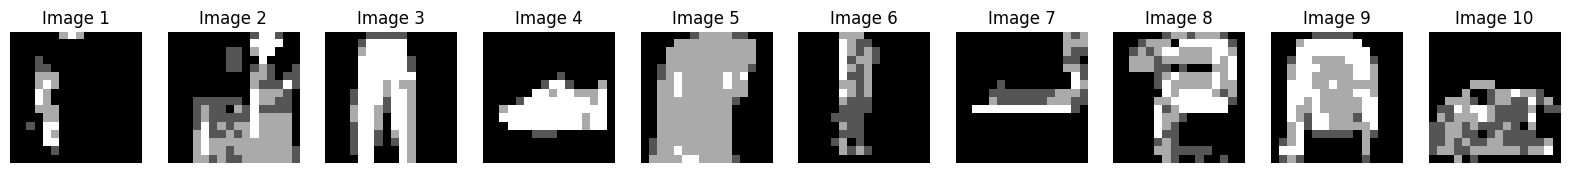

469/469 [==============================] - 32s 67ms/step - loss: 0.3429
Epoch 31/150
469/469 [==============================] - ETA: 0s - loss: 0.3423

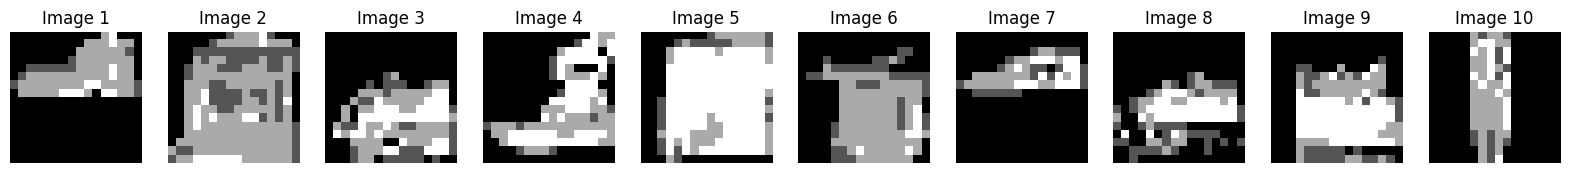

469/469 [==============================] - 32s 68ms/step - loss: 0.3423
Epoch 32/150
469/469 [==============================] - ETA: 0s - loss: 0.3418

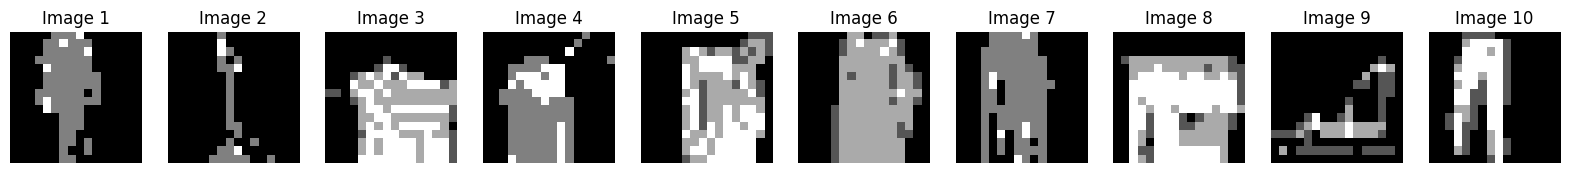

469/469 [==============================] - 33s 70ms/step - loss: 0.3418
Epoch 33/150
469/469 [==============================] - ETA: 0s - loss: 0.3415

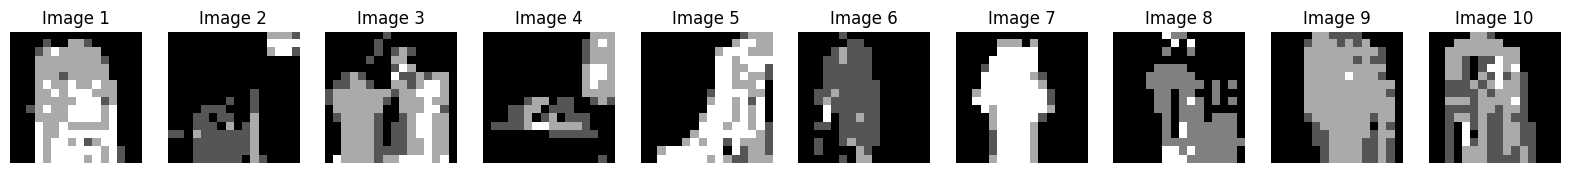

469/469 [==============================] - 33s 71ms/step - loss: 0.3415
Epoch 34/150
469/469 [==============================] - ETA: 0s - loss: 0.3409

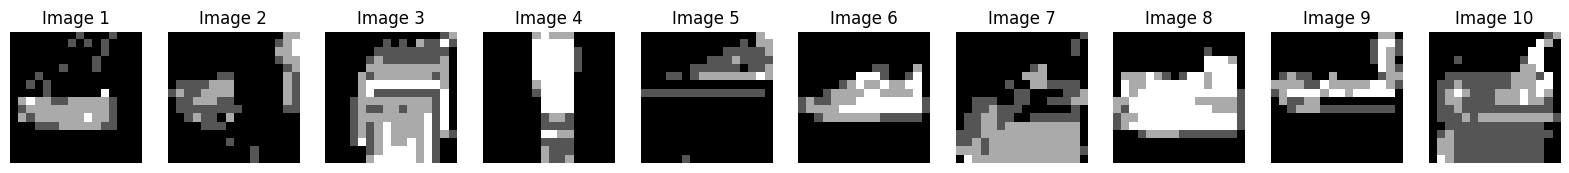

469/469 [==============================] - 32s 68ms/step - loss: 0.3409
Epoch 35/150
468/469 [============================>.] - ETA: 0s - loss: 0.3408

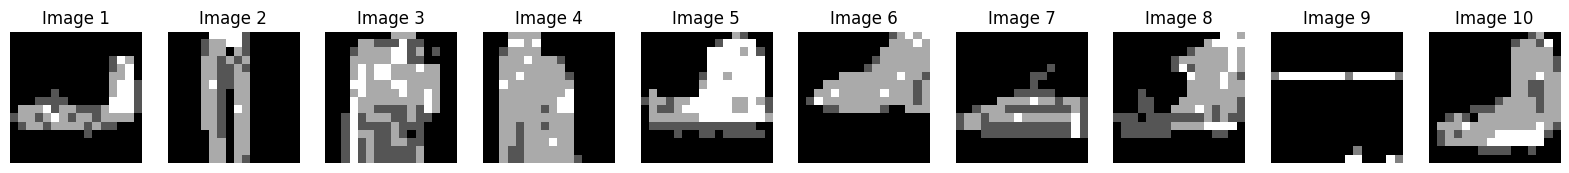

469/469 [==============================] - 33s 71ms/step - loss: 0.3408
Epoch 36/150
469/469 [==============================] - ETA: 0s - loss: 0.3400

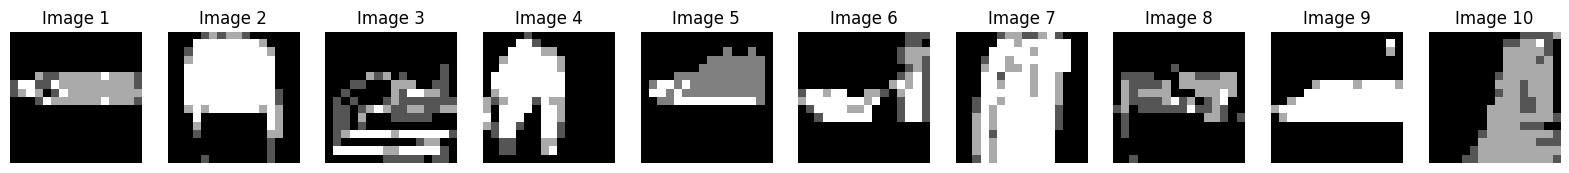

469/469 [==============================] - 32s 68ms/step - loss: 0.3400
Epoch 37/150
469/469 [==============================] - ETA: 0s - loss: 0.3395

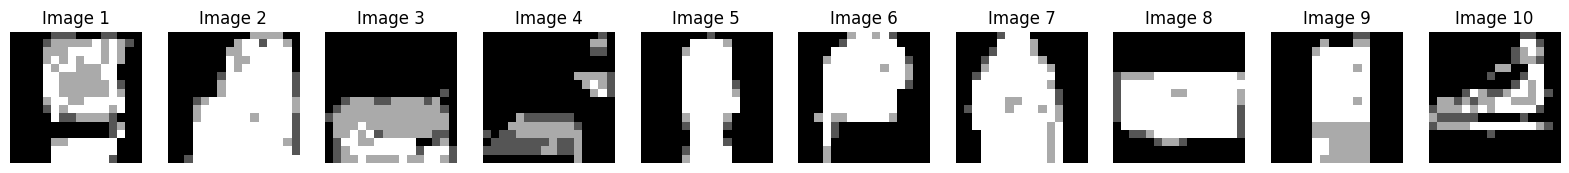

469/469 [==============================] - 31s 67ms/step - loss: 0.3395
Epoch 38/150
469/469 [==============================] - ETA: 0s - loss: 0.3392

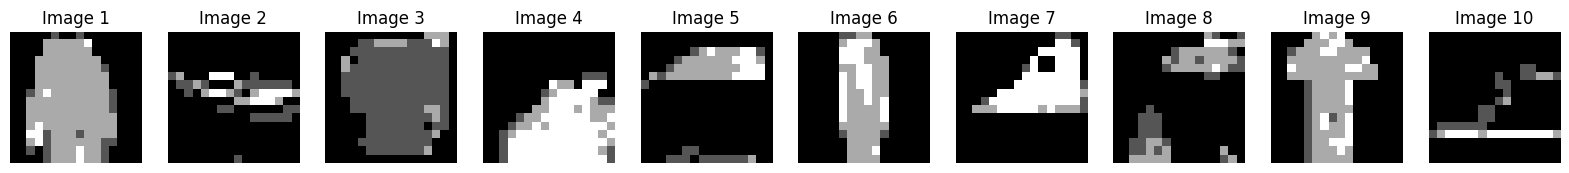

469/469 [==============================] - 31s 67ms/step - loss: 0.3392
Epoch 39/150
469/469 [==============================] - ETA: 0s - loss: 0.3391

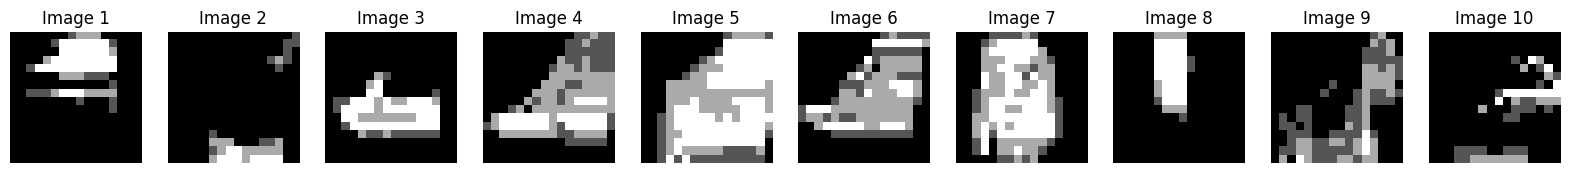

469/469 [==============================] - 32s 67ms/step - loss: 0.3391
Epoch 40/150
467/469 [============================>.] - ETA: 0s - loss: 0.3385

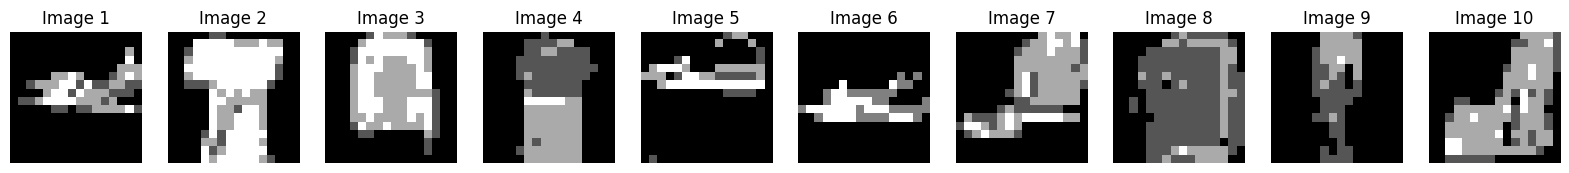

469/469 [==============================] - 32s 69ms/step - loss: 0.3385
Epoch 41/150
467/469 [============================>.] - ETA: 0s - loss: 0.3381

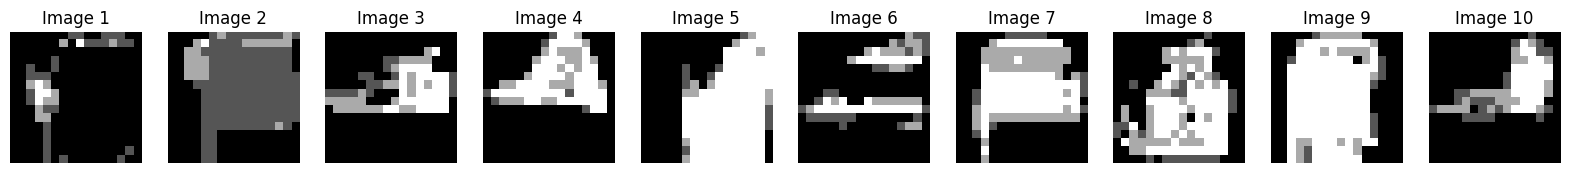

469/469 [==============================] - 30s 65ms/step - loss: 0.3381
Epoch 42/150
469/469 [==============================] - ETA: 0s - loss: 0.3379

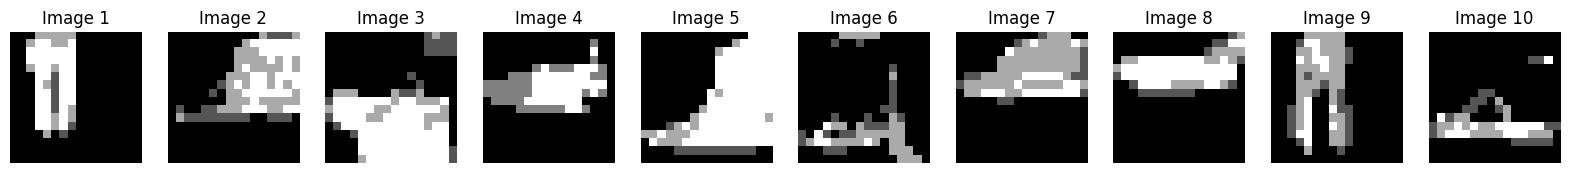

469/469 [==============================] - 33s 70ms/step - loss: 0.3379
Epoch 43/150
469/469 [==============================] - ETA: 0s - loss: 0.3376

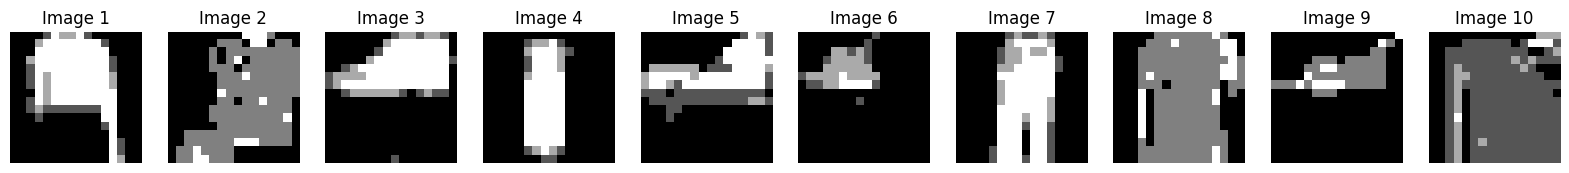

469/469 [==============================] - 31s 67ms/step - loss: 0.3376
Epoch 44/150
469/469 [==============================] - ETA: 0s - loss: 0.3372

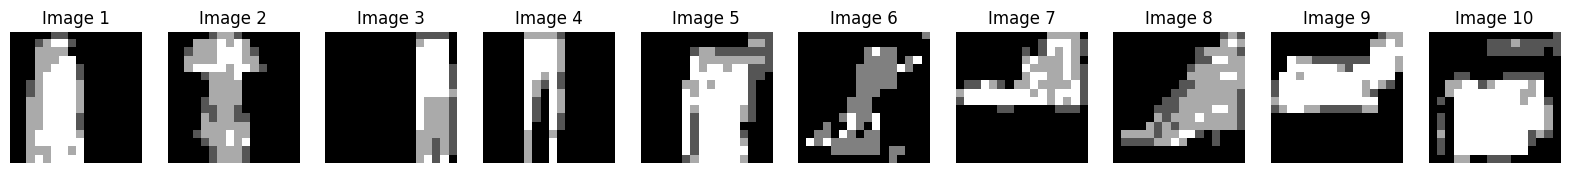

469/469 [==============================] - 31s 66ms/step - loss: 0.3372
Epoch 45/150
467/469 [============================>.] - ETA: 0s - loss: 0.3369

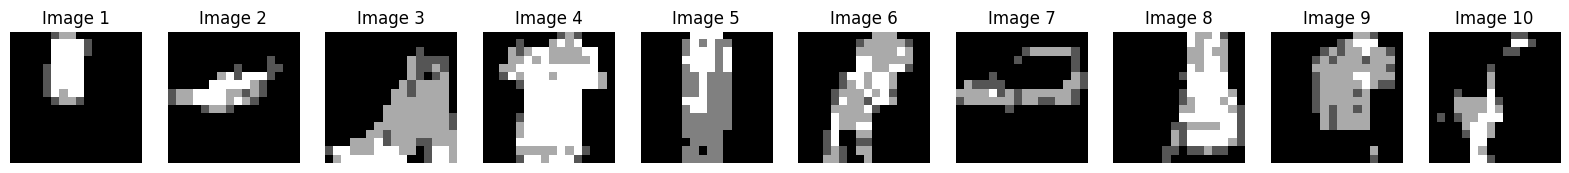

469/469 [==============================] - 32s 68ms/step - loss: 0.3369
Epoch 46/150
469/469 [==============================] - ETA: 0s - loss: 0.3365

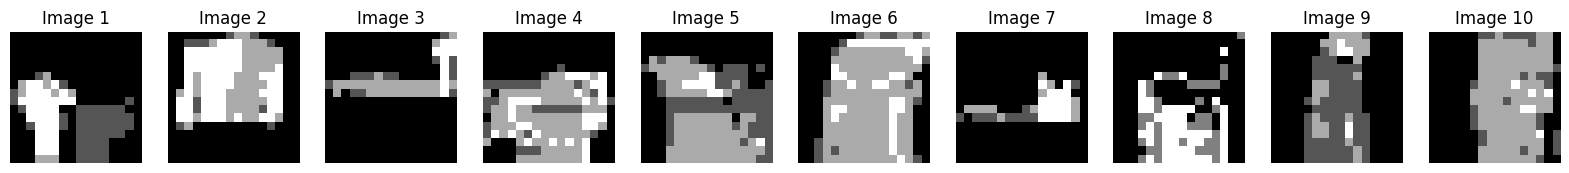

469/469 [==============================] - 31s 67ms/step - loss: 0.3365
Epoch 47/150
469/469 [==============================] - ETA: 0s - loss: 0.3362

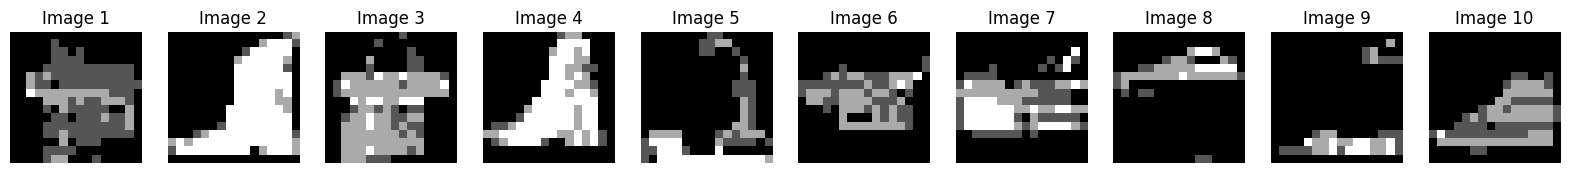

469/469 [==============================] - 32s 67ms/step - loss: 0.3362
Epoch 48/150
469/469 [==============================] - ETA: 0s - loss: 0.3360

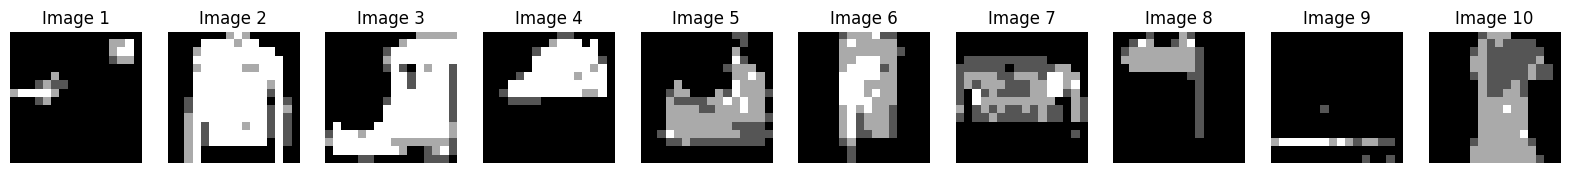

469/469 [==============================] - 32s 68ms/step - loss: 0.3360
Epoch 49/150
469/469 [==============================] - ETA: 0s - loss: 0.3358

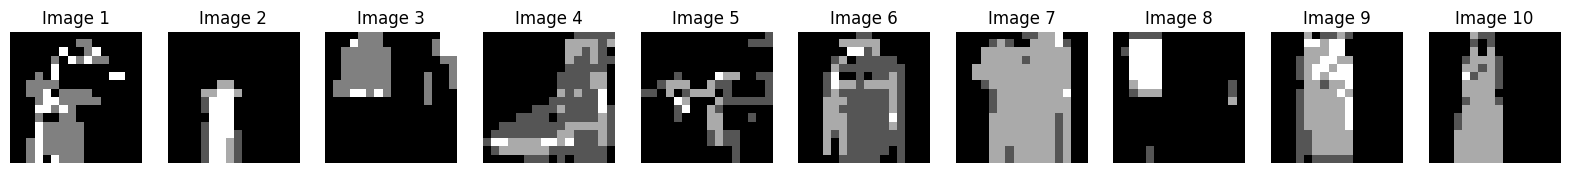

469/469 [==============================] - 34s 72ms/step - loss: 0.3358
Epoch 50/150
469/469 [==============================] - ETA: 0s - loss: 0.3353

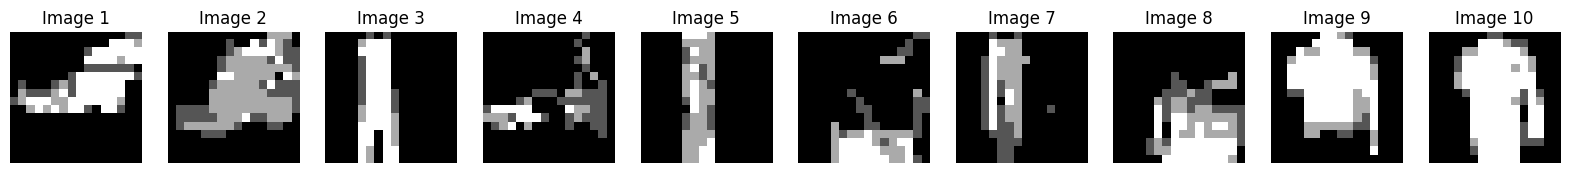

469/469 [==============================] - 30s 65ms/step - loss: 0.3353
Epoch 51/150
469/469 [==============================] - ETA: 0s - loss: 0.3353

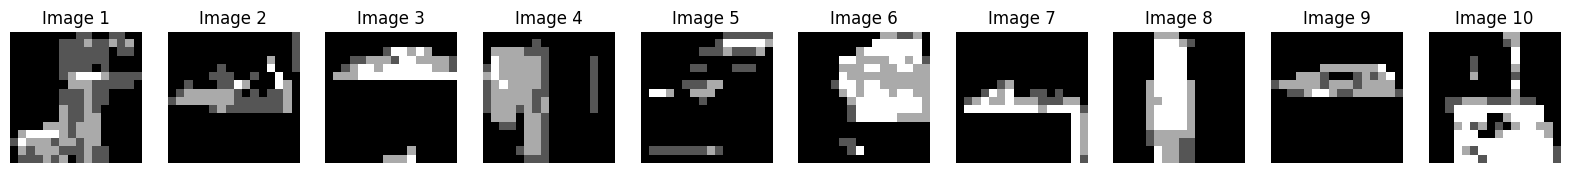

469/469 [==============================] - 32s 68ms/step - loss: 0.3353
Epoch 52/150
469/469 [==============================] - ETA: 0s - loss: 0.3350

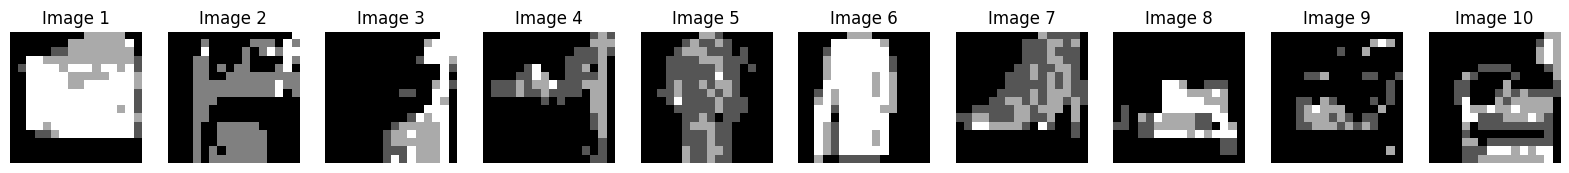

469/469 [==============================] - 31s 67ms/step - loss: 0.3350
Epoch 53/150
469/469 [==============================] - ETA: 0s - loss: 0.3347

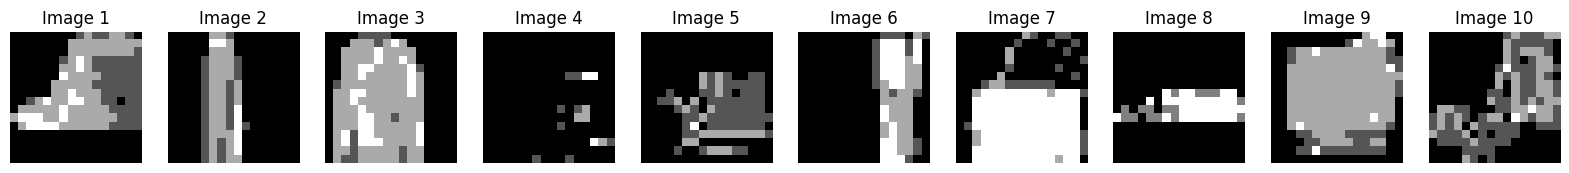

469/469 [==============================] - 31s 66ms/step - loss: 0.3347
Epoch 54/150
467/469 [============================>.] - ETA: 0s - loss: 0.3347

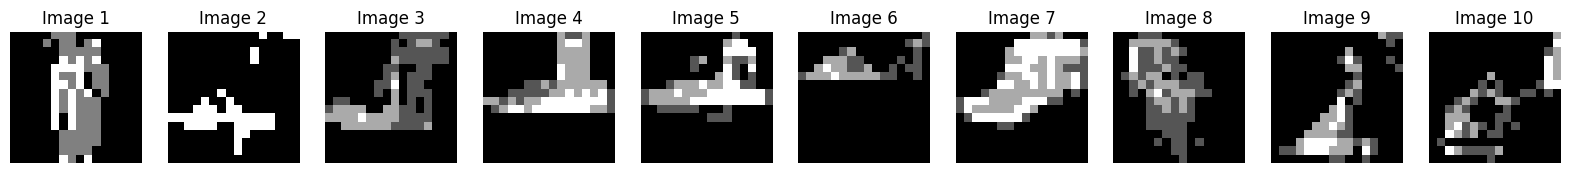

469/469 [==============================] - 32s 68ms/step - loss: 0.3347
Epoch 55/150
469/469 [==============================] - ETA: 0s - loss: 0.3342

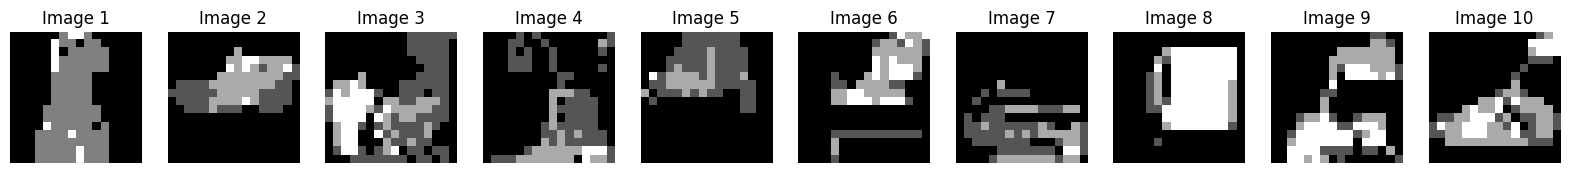

469/469 [==============================] - 30s 65ms/step - loss: 0.3342
Epoch 56/150
469/469 [==============================] - ETA: 0s - loss: 0.3340

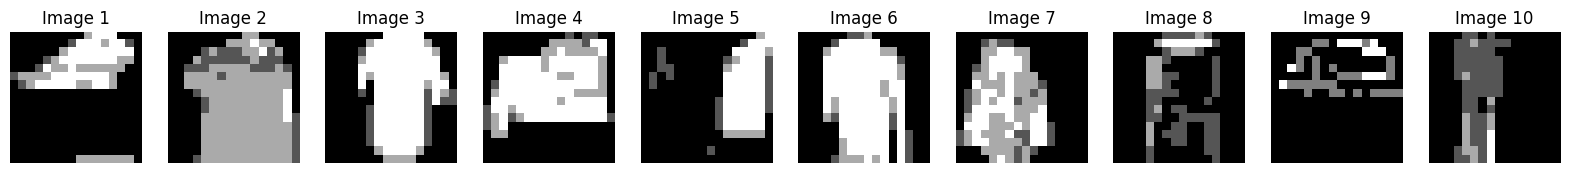

469/469 [==============================] - 33s 70ms/step - loss: 0.3340
Epoch 57/150
469/469 [==============================] - ETA: 0s - loss: 0.3336

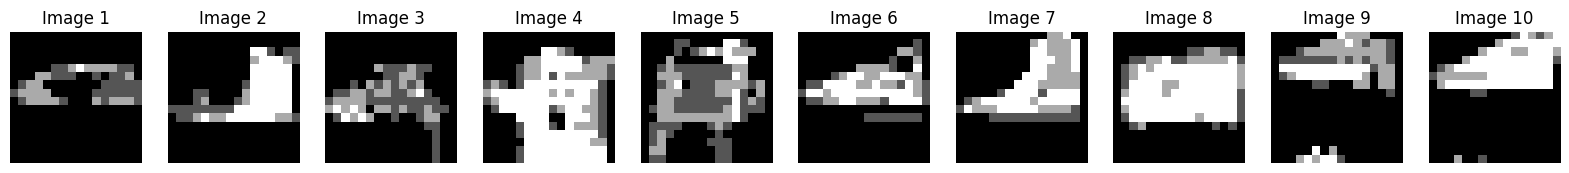

469/469 [==============================] - 31s 67ms/step - loss: 0.3336
Epoch 58/150
469/469 [==============================] - ETA: 0s - loss: 0.3335

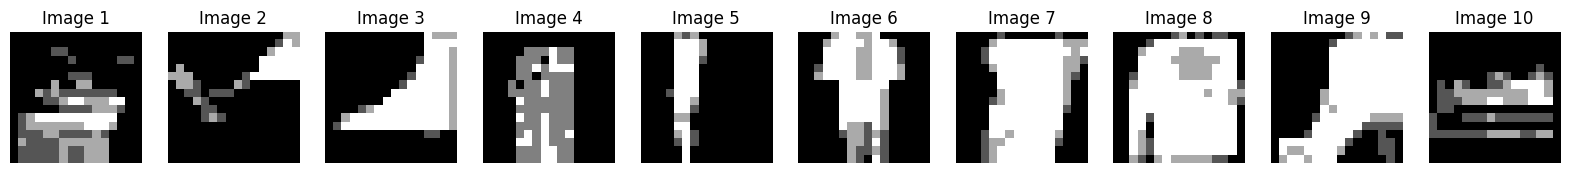

469/469 [==============================] - 32s 68ms/step - loss: 0.3335
Epoch 59/150
469/469 [==============================] - ETA: 0s - loss: 0.3333

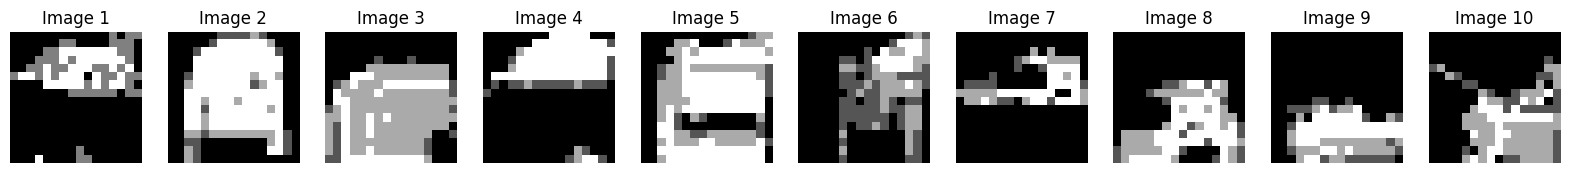

469/469 [==============================] - 31s 66ms/step - loss: 0.3333
Epoch 60/150
469/469 [==============================] - ETA: 0s - loss: 0.3333

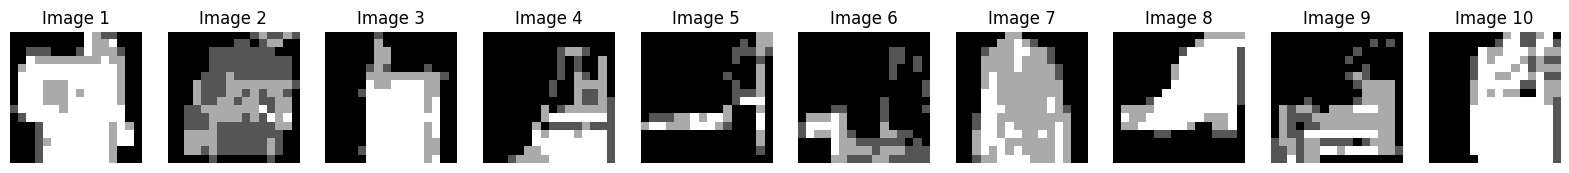

469/469 [==============================] - 33s 70ms/step - loss: 0.3333
Epoch 61/150
469/469 [==============================] - ETA: 0s - loss: 0.3329

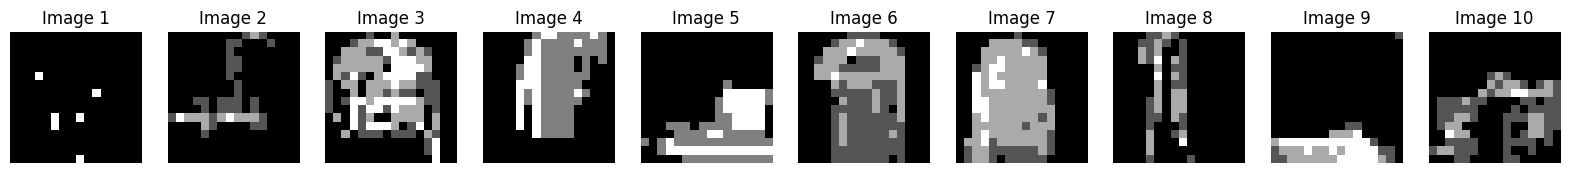

469/469 [==============================] - 31s 67ms/step - loss: 0.3329
Epoch 62/150
469/469 [==============================] - ETA: 0s - loss: 0.3329

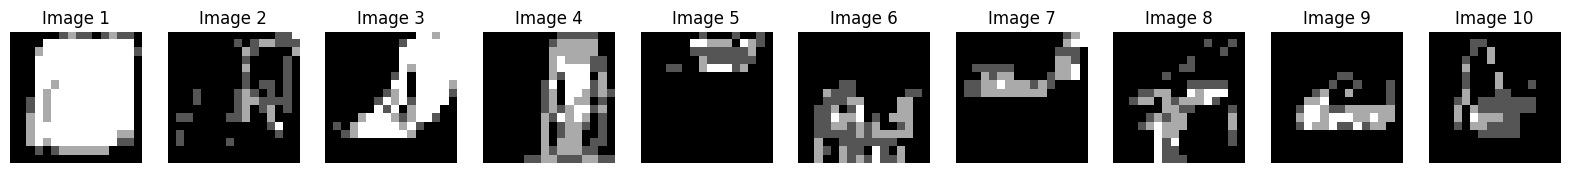

469/469 [==============================] - 31s 66ms/step - loss: 0.3329
Epoch 63/150
469/469 [==============================] - ETA: 0s - loss: 0.3326

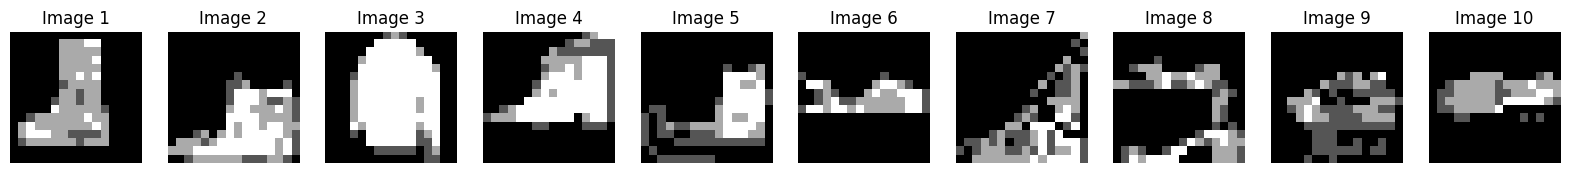

469/469 [==============================] - 33s 69ms/step - loss: 0.3326
Epoch 64/150
469/469 [==============================] - ETA: 0s - loss: 0.3322

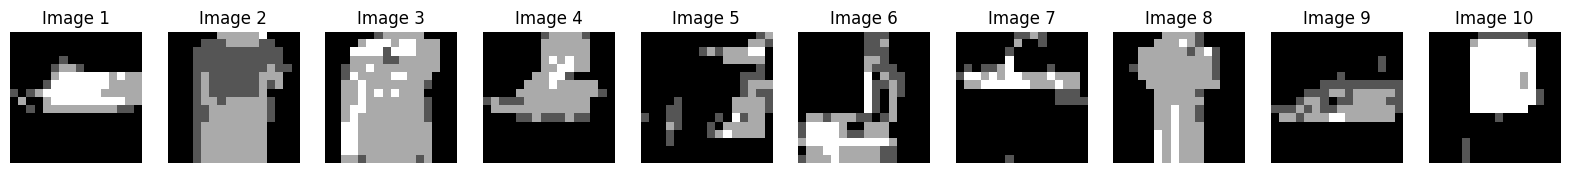

469/469 [==============================] - 31s 66ms/step - loss: 0.3322
Epoch 65/150
469/469 [==============================] - ETA: 0s - loss: 0.3322

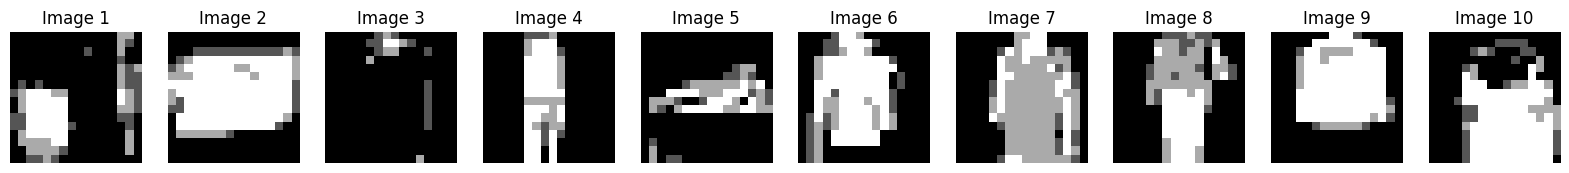

469/469 [==============================] - 32s 69ms/step - loss: 0.3322
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.3321

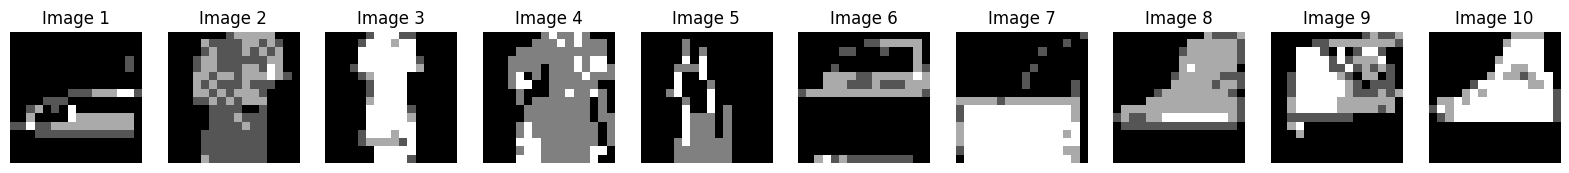

469/469 [==============================] - 31s 67ms/step - loss: 0.3321
Epoch 67/150
469/469 [==============================] - ETA: 0s - loss: 0.3319

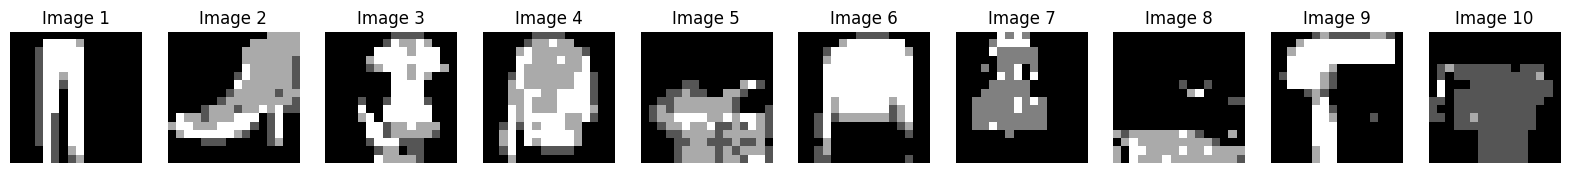

469/469 [==============================] - 32s 69ms/step - loss: 0.3319
Epoch 68/150
469/469 [==============================] - ETA: 0s - loss: 0.3315

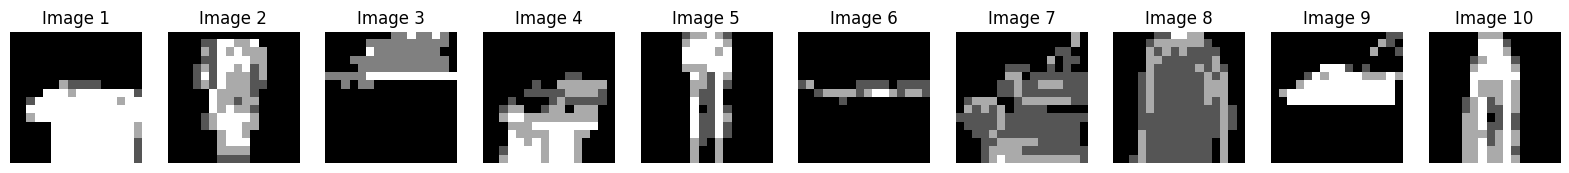

469/469 [==============================] - 32s 68ms/step - loss: 0.3315
Epoch 69/150
469/469 [==============================] - ETA: 0s - loss: 0.3314

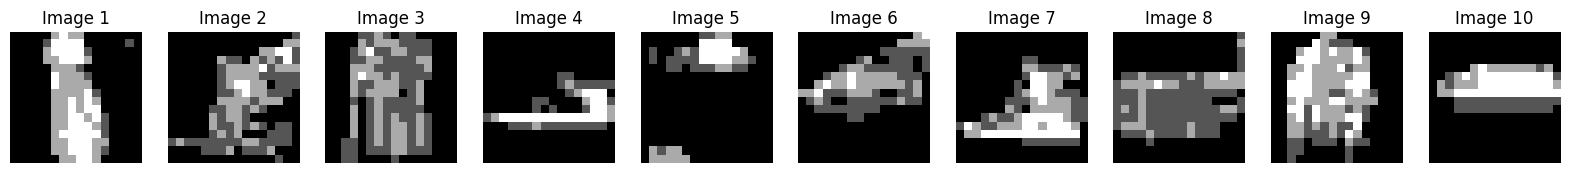

469/469 [==============================] - 32s 67ms/step - loss: 0.3314
Epoch 70/150
469/469 [==============================] - ETA: 0s - loss: 0.3313

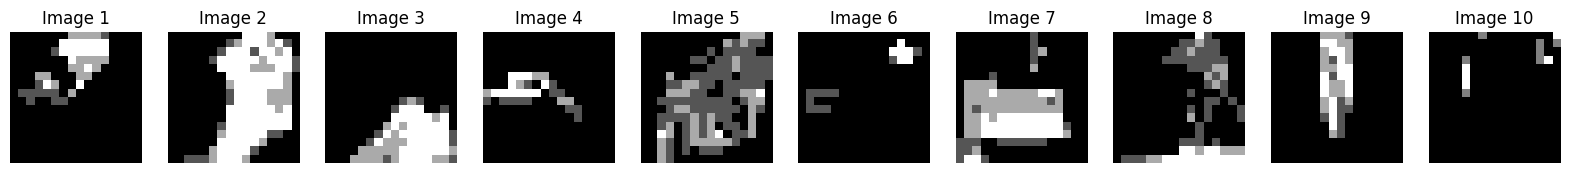

469/469 [==============================] - 32s 68ms/step - loss: 0.3313
Epoch 71/150
469/469 [==============================] - ETA: 0s - loss: 0.3312

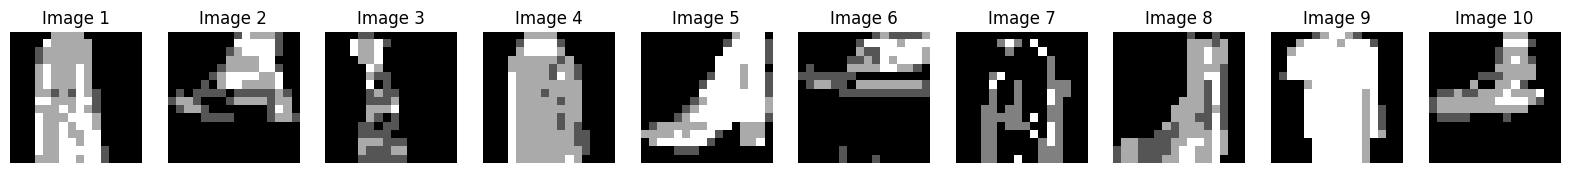

469/469 [==============================] - 31s 67ms/step - loss: 0.3312
Epoch 72/150
469/469 [==============================] - ETA: 0s - loss: 0.3310

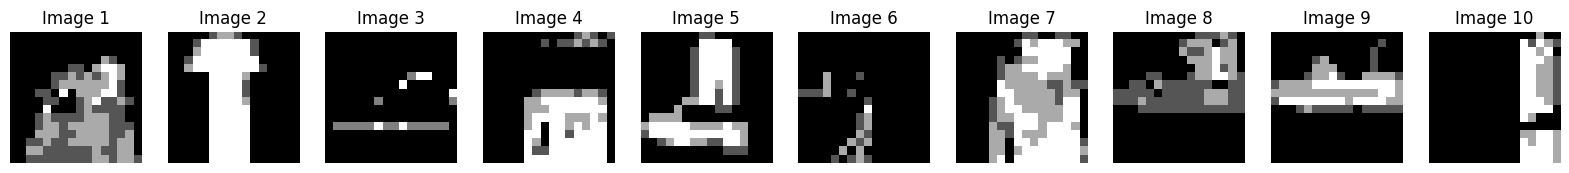

469/469 [==============================] - 33s 70ms/step - loss: 0.3310
Epoch 73/150
469/469 [==============================] - ETA: 0s - loss: 0.3308

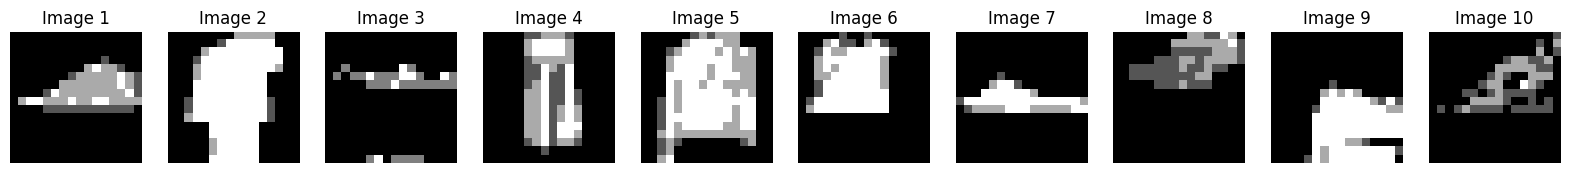

469/469 [==============================] - 31s 65ms/step - loss: 0.3308
Epoch 74/150
469/469 [==============================] - ETA: 0s - loss: 0.3308

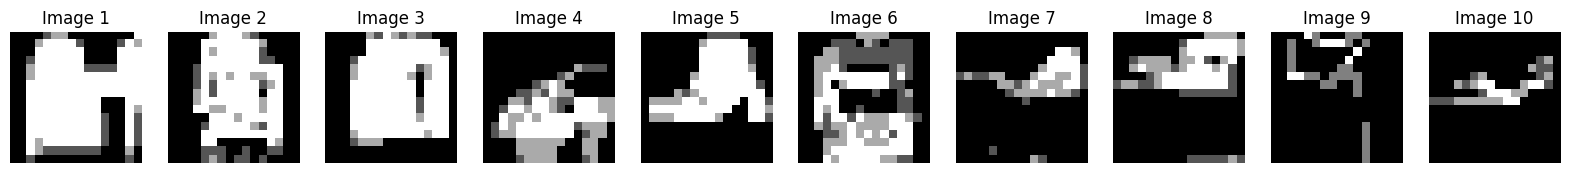

469/469 [==============================] - 32s 69ms/step - loss: 0.3308
Epoch 75/150
469/469 [==============================] - ETA: 0s - loss: 0.3304

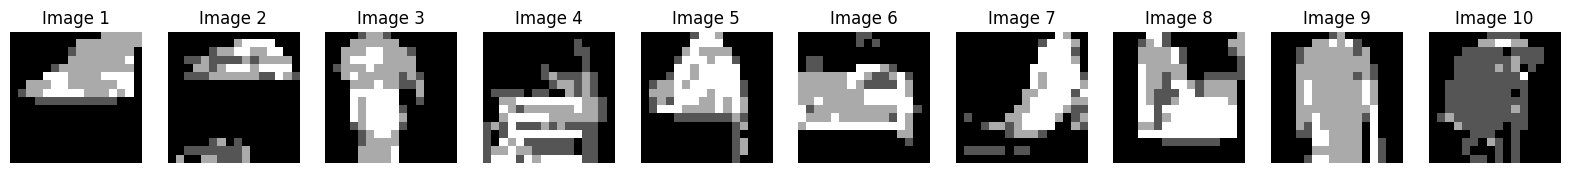

469/469 [==============================] - 32s 67ms/step - loss: 0.3304
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.3303

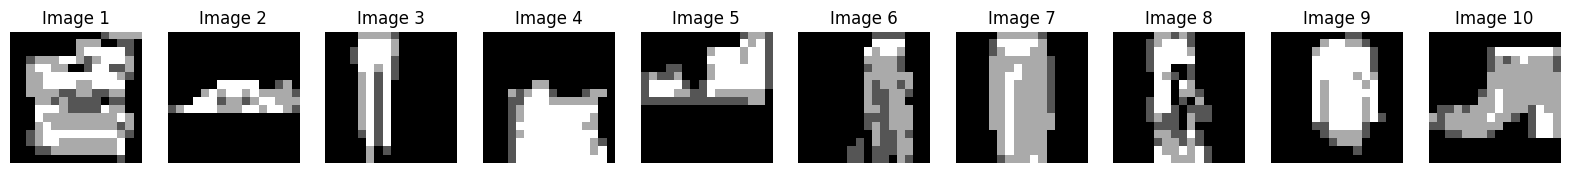

469/469 [==============================] - 31s 66ms/step - loss: 0.3303
Epoch 77/150
469/469 [==============================] - ETA: 0s - loss: 0.3302

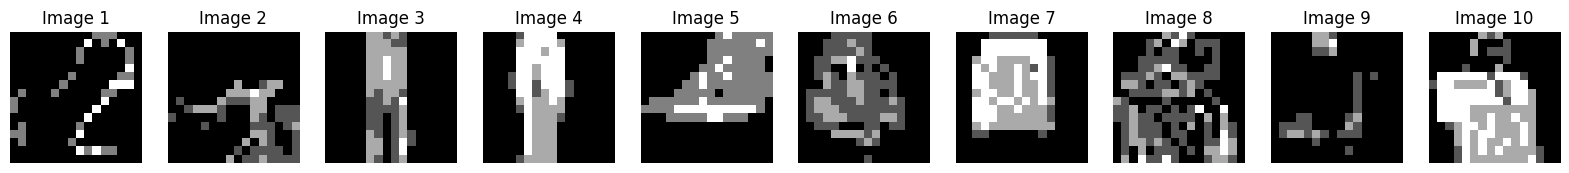

469/469 [==============================] - 33s 69ms/step - loss: 0.3302
Epoch 78/150
467/469 [============================>.] - ETA: 0s - loss: 0.3300

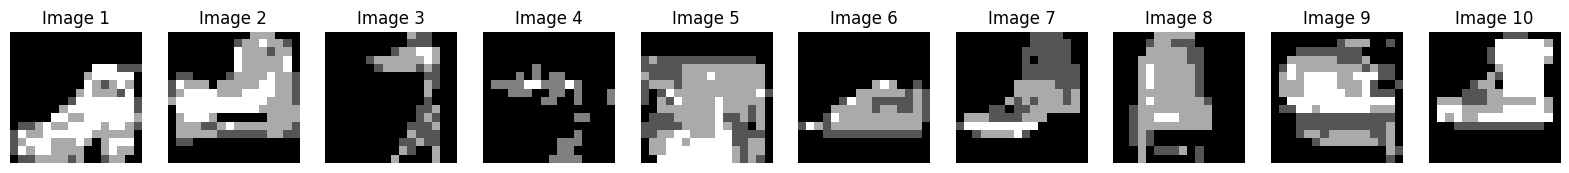

469/469 [==============================] - 31s 67ms/step - loss: 0.3301
Epoch 79/150
469/469 [==============================] - ETA: 0s - loss: 0.3299

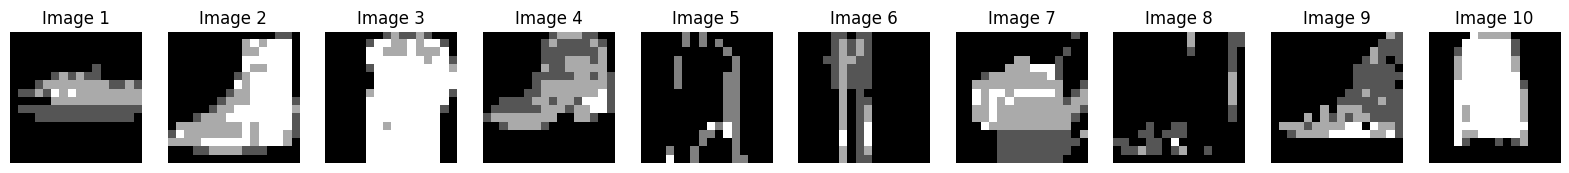

469/469 [==============================] - 32s 69ms/step - loss: 0.3299
Epoch 80/150
469/469 [==============================] - ETA: 0s - loss: 0.3298

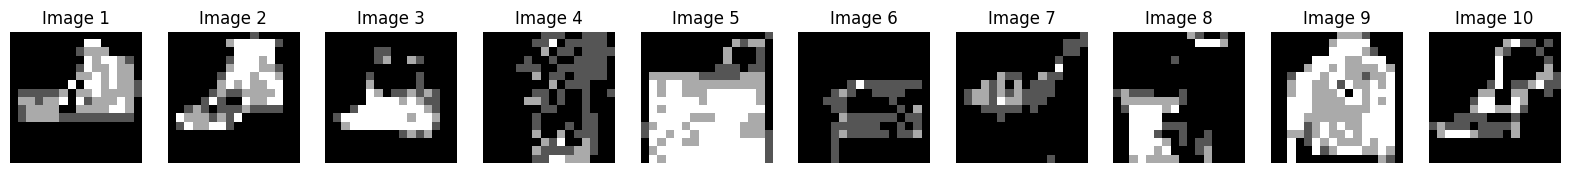

469/469 [==============================] - 31s 67ms/step - loss: 0.3298
Epoch 81/150
469/469 [==============================] - ETA: 0s - loss: 0.3296

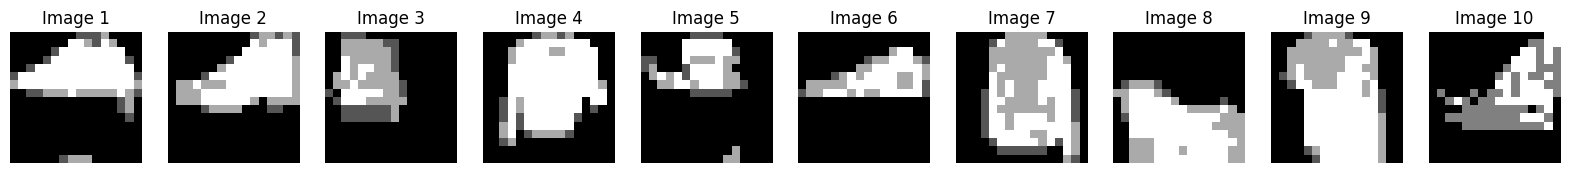

469/469 [==============================] - 33s 70ms/step - loss: 0.3296
Epoch 82/150
469/469 [==============================] - ETA: 0s - loss: 0.3296

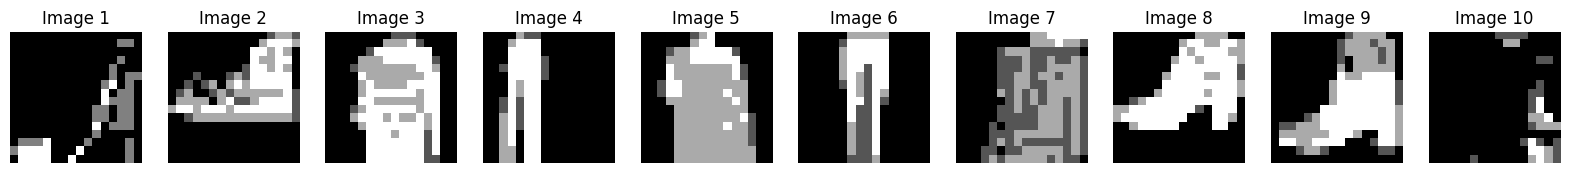

469/469 [==============================] - 31s 66ms/step - loss: 0.3296
Epoch 83/150
469/469 [==============================] - ETA: 0s - loss: 0.3292

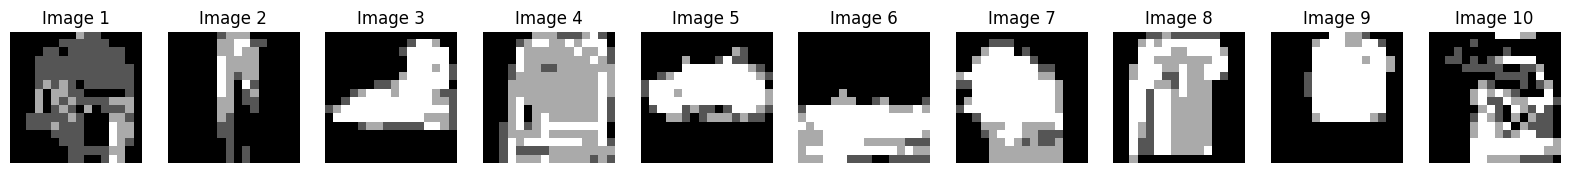

469/469 [==============================] - 31s 67ms/step - loss: 0.3292
Epoch 84/150
469/469 [==============================] - ETA: 0s - loss: 0.3293

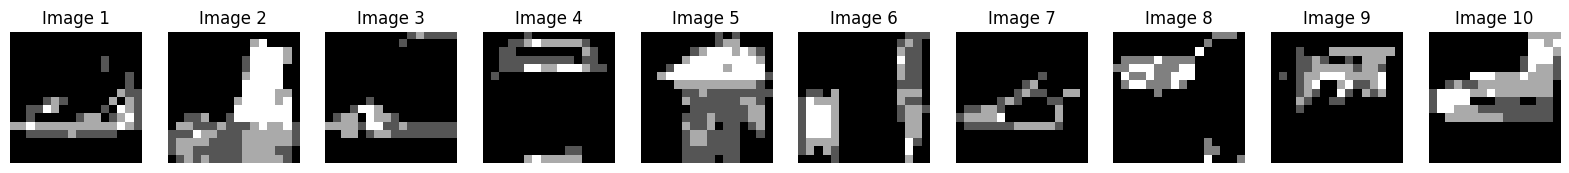

469/469 [==============================] - 32s 69ms/step - loss: 0.3293
Epoch 85/150
469/469 [==============================] - ETA: 0s - loss: 0.3291

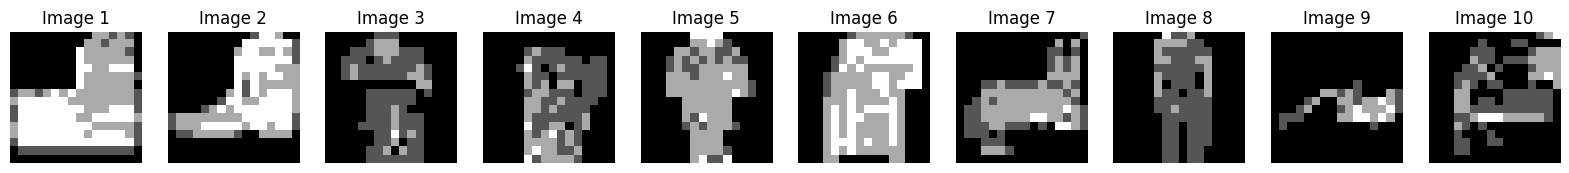

469/469 [==============================] - 31s 67ms/step - loss: 0.3291
Epoch 86/150
469/469 [==============================] - ETA: 0s - loss: 0.3290

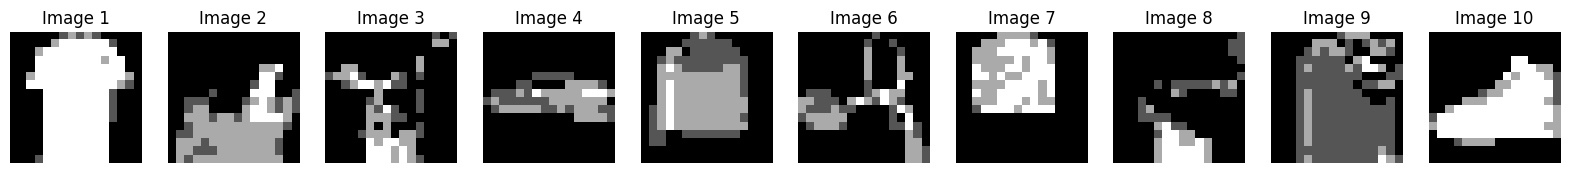

469/469 [==============================] - 33s 70ms/step - loss: 0.3290
Epoch 87/150
469/469 [==============================] - ETA: 0s - loss: 0.3288

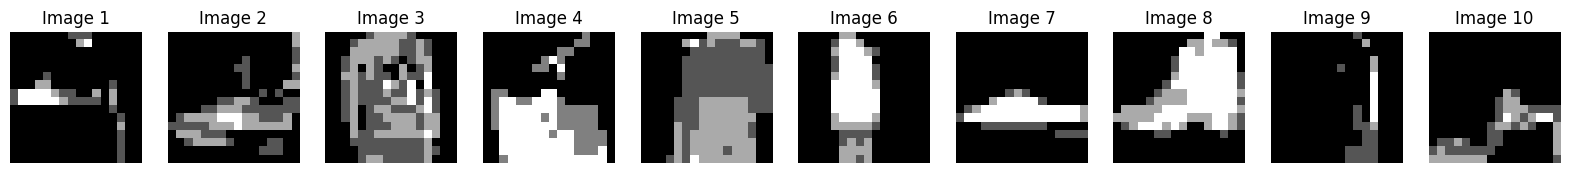

469/469 [==============================] - 31s 66ms/step - loss: 0.3288
Epoch 88/150
469/469 [==============================] - ETA: 0s - loss: 0.3286

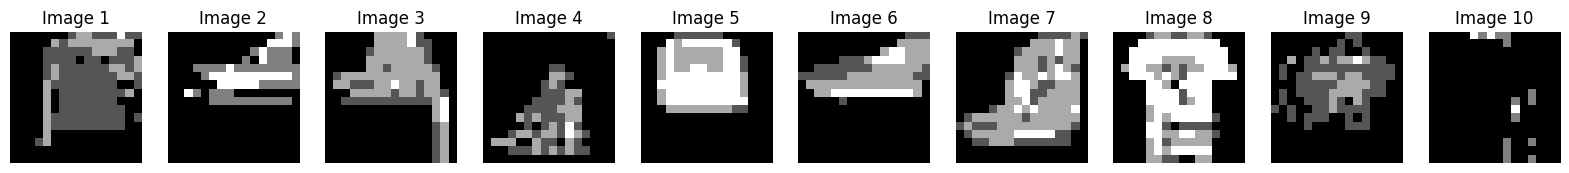

469/469 [==============================] - 32s 69ms/step - loss: 0.3286
Epoch 89/150
469/469 [==============================] - ETA: 0s - loss: 0.3287

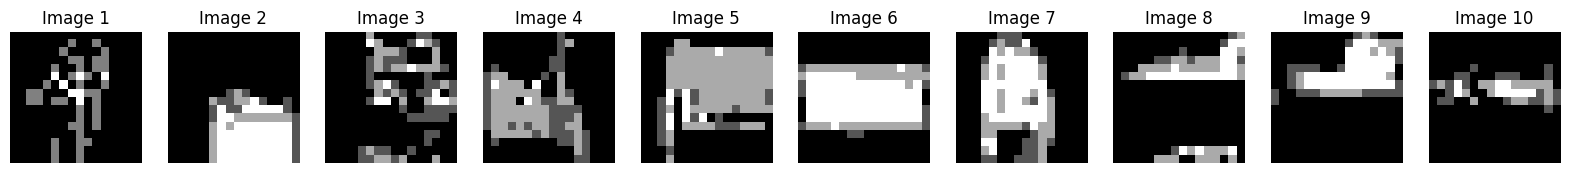

469/469 [==============================] - 32s 68ms/step - loss: 0.3287
Epoch 90/150
469/469 [==============================] - ETA: 0s - loss: 0.3286

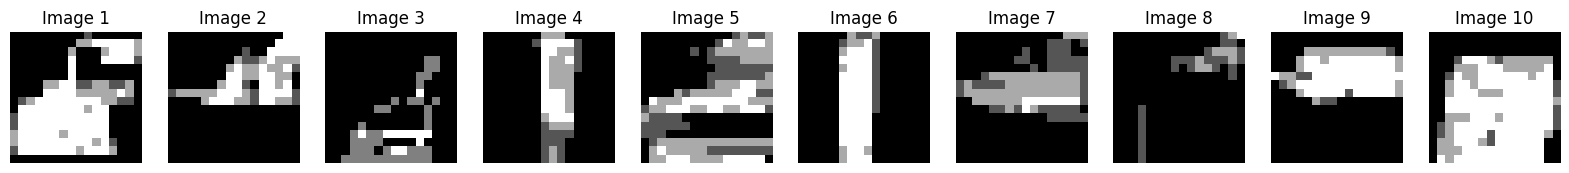

469/469 [==============================] - 31s 67ms/step - loss: 0.3286
Epoch 91/150
469/469 [==============================] - ETA: 0s - loss: 0.3284

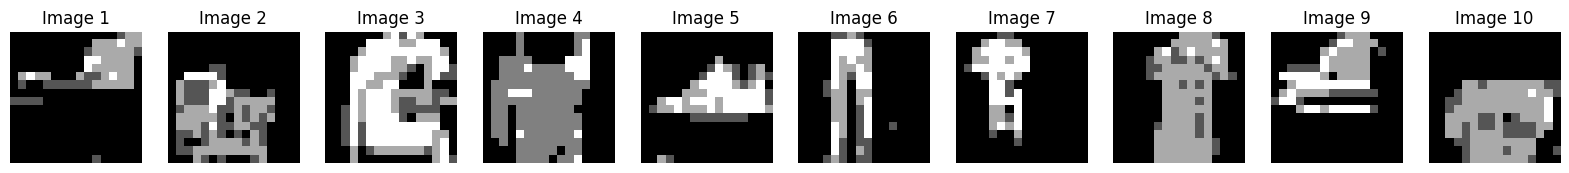

469/469 [==============================] - 32s 67ms/step - loss: 0.3284
Epoch 92/150
469/469 [==============================] - ETA: 0s - loss: 0.3282

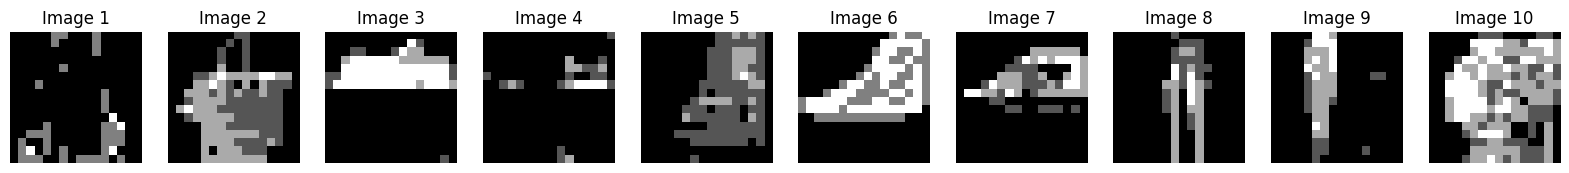

469/469 [==============================] - 32s 68ms/step - loss: 0.3282
Epoch 93/150
469/469 [==============================] - ETA: 0s - loss: 0.3281

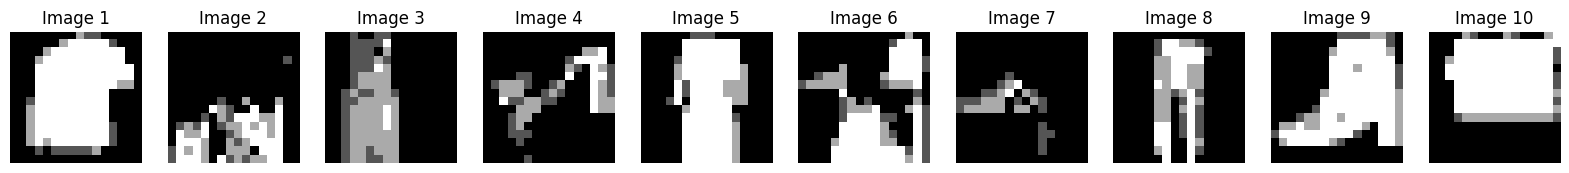

469/469 [==============================] - 32s 69ms/step - loss: 0.3281
Epoch 94/150
467/469 [============================>.] - ETA: 0s - loss: 0.3279

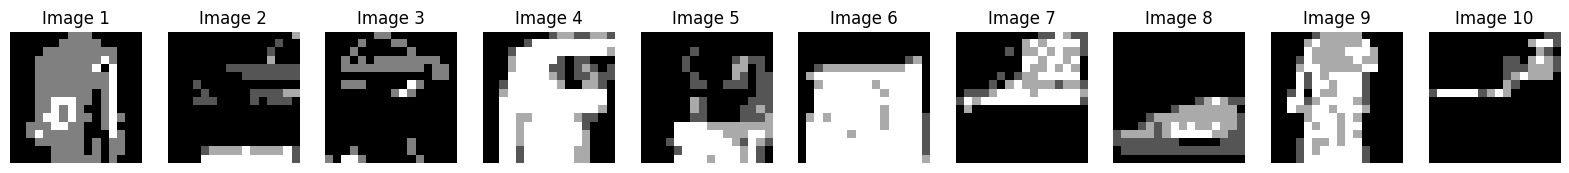

469/469 [==============================] - 31s 66ms/step - loss: 0.3280
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.3280

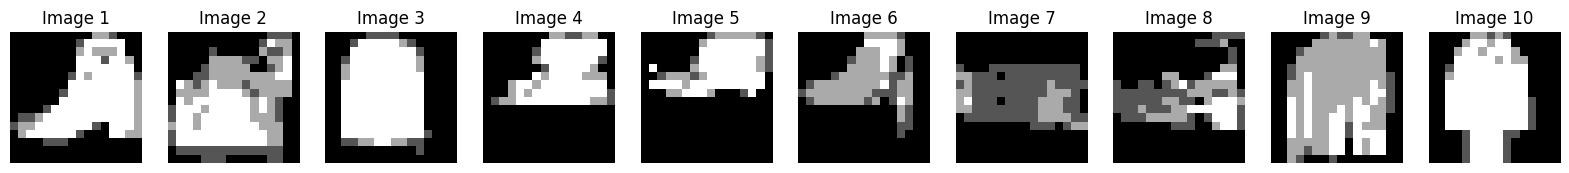

469/469 [==============================] - 33s 70ms/step - loss: 0.3280
Epoch 96/150
469/469 [==============================] - ETA: 0s - loss: 0.3278

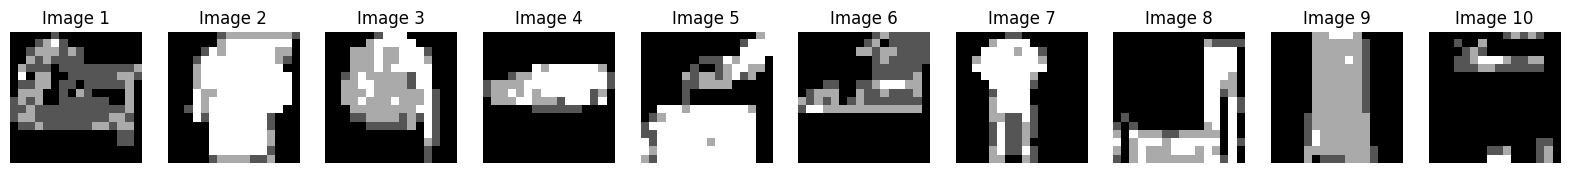

469/469 [==============================] - 31s 66ms/step - loss: 0.3278
Epoch 97/150
469/469 [==============================] - ETA: 0s - loss: 0.3276

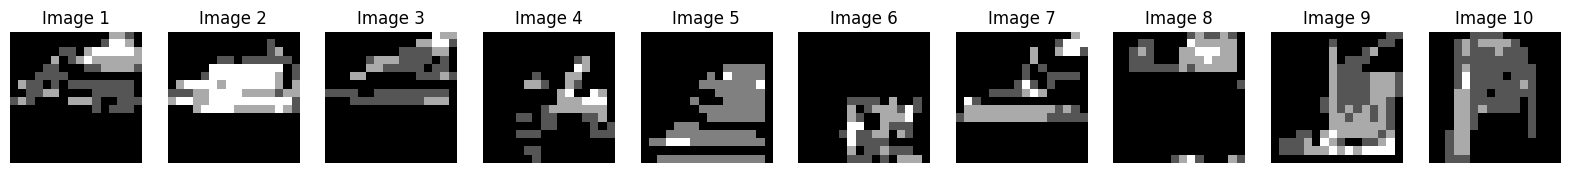

469/469 [==============================] - 31s 67ms/step - loss: 0.3276
Epoch 98/150
469/469 [==============================] - ETA: 0s - loss: 0.3276

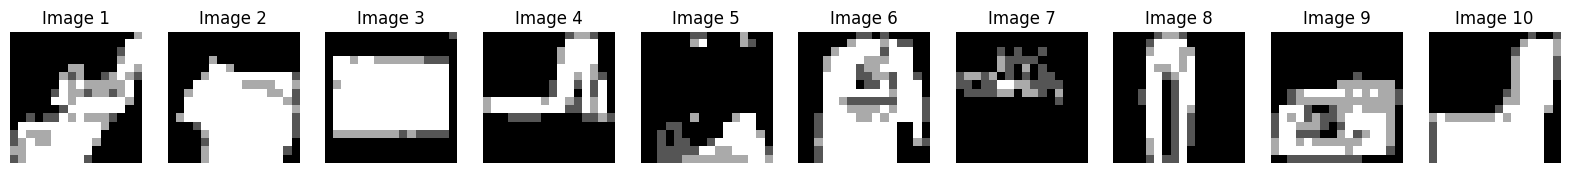

469/469 [==============================] - 32s 69ms/step - loss: 0.3276
Epoch 99/150
469/469 [==============================] - ETA: 0s - loss: 0.3274

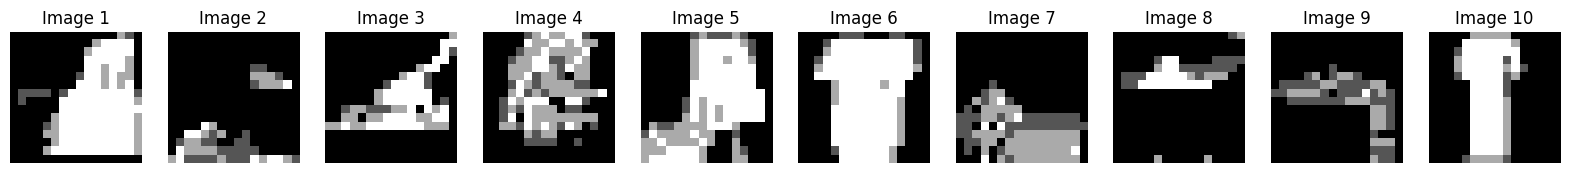

469/469 [==============================] - 31s 66ms/step - loss: 0.3274
Epoch 100/150
469/469 [==============================] - ETA: 0s - loss: 0.3272

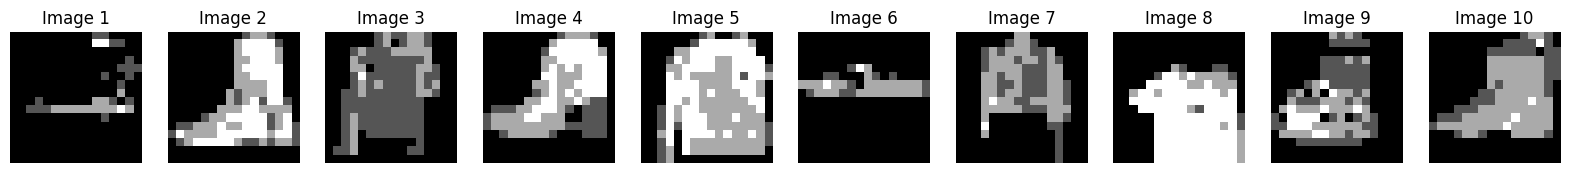

469/469 [==============================] - 33s 70ms/step - loss: 0.3272
Epoch 101/150
469/469 [==============================] - ETA: 0s - loss: 0.3273

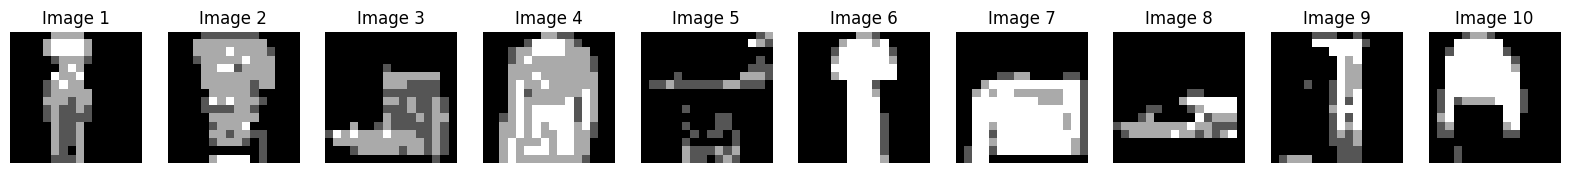

469/469 [==============================] - 31s 66ms/step - loss: 0.3273
Epoch 102/150
469/469 [==============================] - ETA: 0s - loss: 0.3272

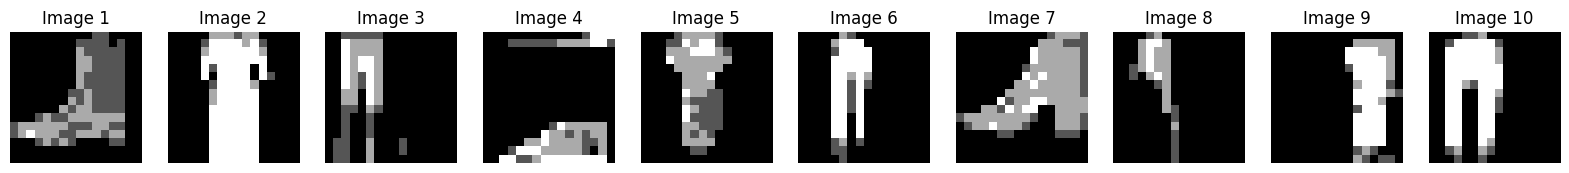

469/469 [==============================] - 33s 69ms/step - loss: 0.3272
Epoch 103/150
469/469 [==============================] - ETA: 0s - loss: 0.3271

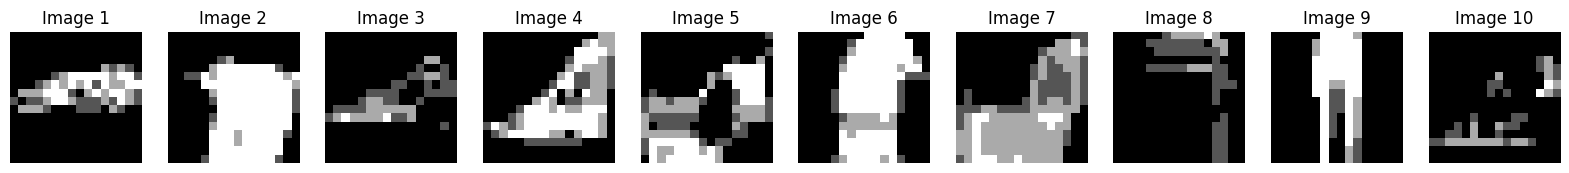

469/469 [==============================] - 31s 67ms/step - loss: 0.3271
Epoch 104/150
467/469 [============================>.] - ETA: 0s - loss: 0.3269

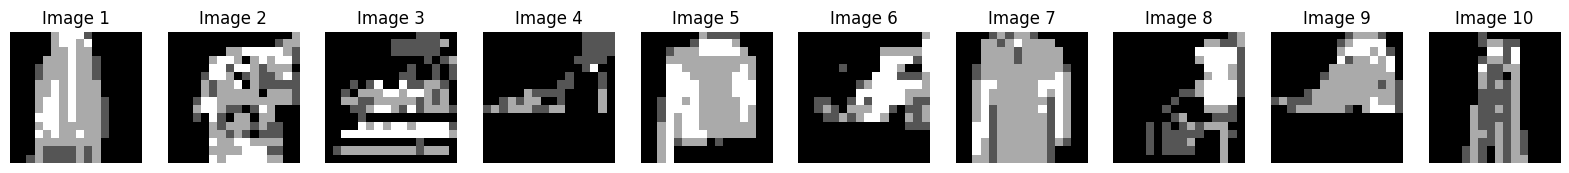

469/469 [==============================] - 32s 68ms/step - loss: 0.3269
Epoch 105/150
469/469 [==============================] - ETA: 0s - loss: 0.3269

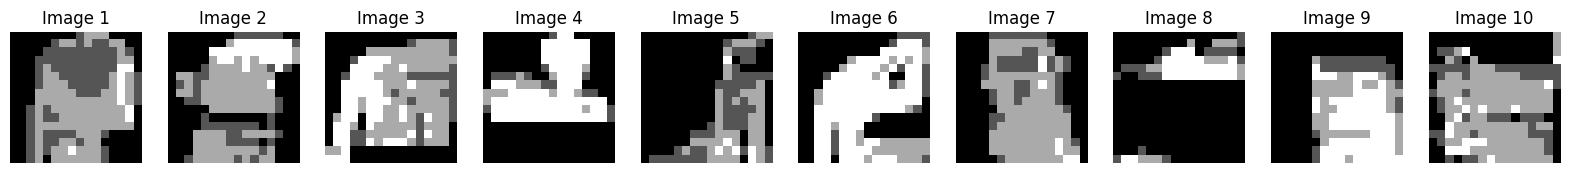

469/469 [==============================] - 31s 67ms/step - loss: 0.3269
Epoch 106/150
469/469 [==============================] - ETA: 0s - loss: 0.3266

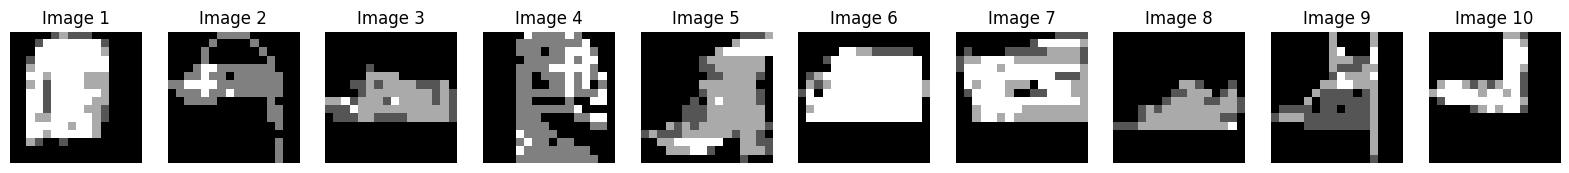

469/469 [==============================] - 32s 68ms/step - loss: 0.3266
Epoch 107/150
469/469 [==============================] - ETA: 0s - loss: 0.3266

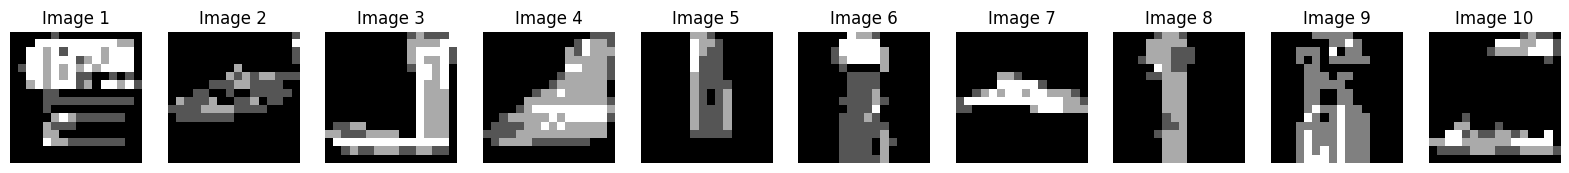

469/469 [==============================] - 33s 70ms/step - loss: 0.3266
Epoch 108/150
467/469 [============================>.] - ETA: 0s - loss: 0.3265

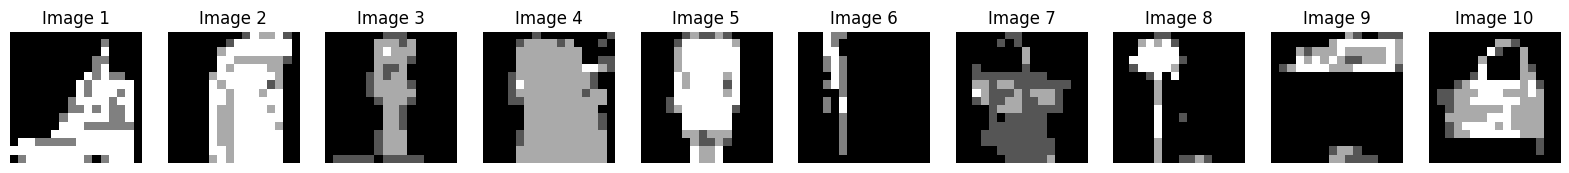

469/469 [==============================] - 31s 65ms/step - loss: 0.3265
Epoch 109/150
469/469 [==============================] - ETA: 0s - loss: 0.3265

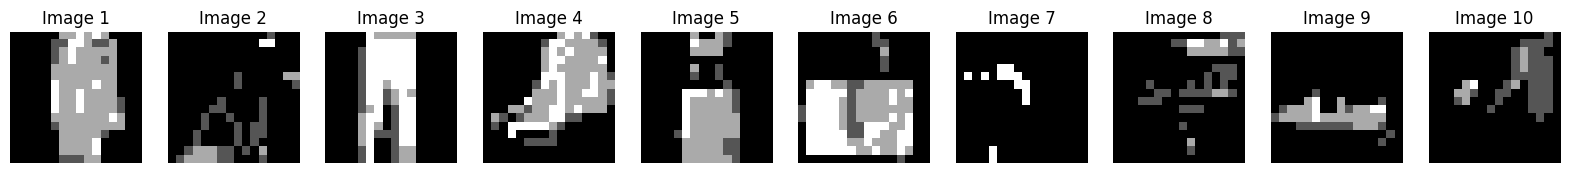

469/469 [==============================] - 33s 70ms/step - loss: 0.3265
Epoch 110/150
469/469 [==============================] - ETA: 0s - loss: 0.3264

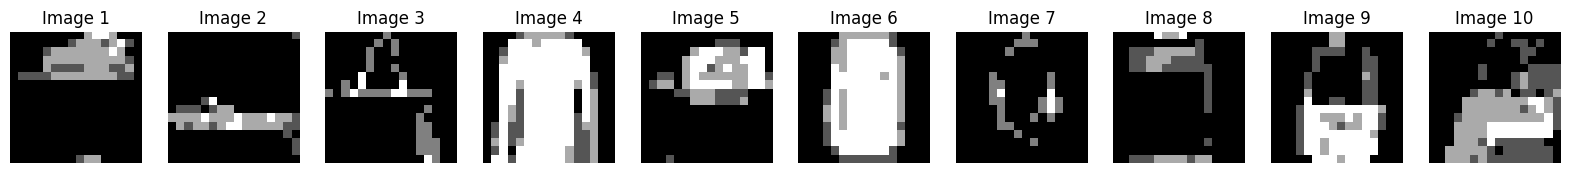

469/469 [==============================] - 31s 67ms/step - loss: 0.3264
Epoch 111/150
469/469 [==============================] - ETA: 0s - loss: 0.3262

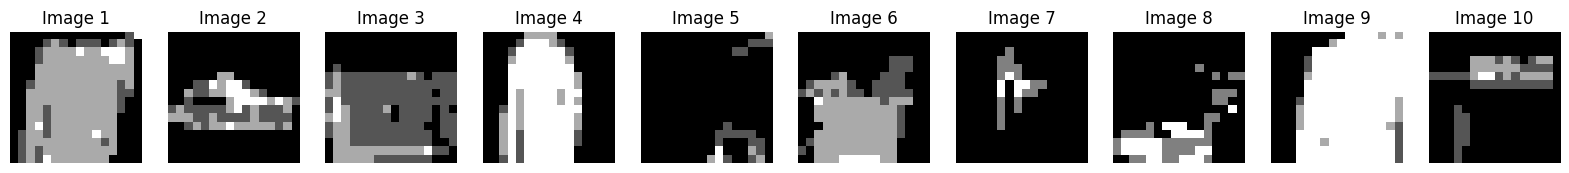

469/469 [==============================] - 31s 67ms/step - loss: 0.3262
Epoch 112/150
469/469 [==============================] - ETA: 0s - loss: 0.3262

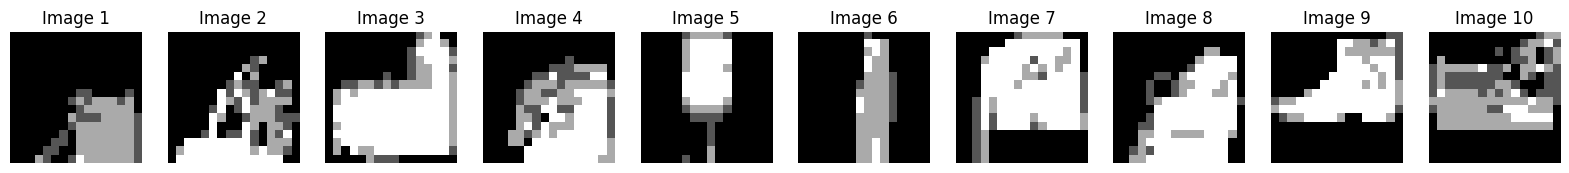

469/469 [==============================] - 32s 69ms/step - loss: 0.3262
Epoch 113/150
469/469 [==============================] - ETA: 0s - loss: 0.3261

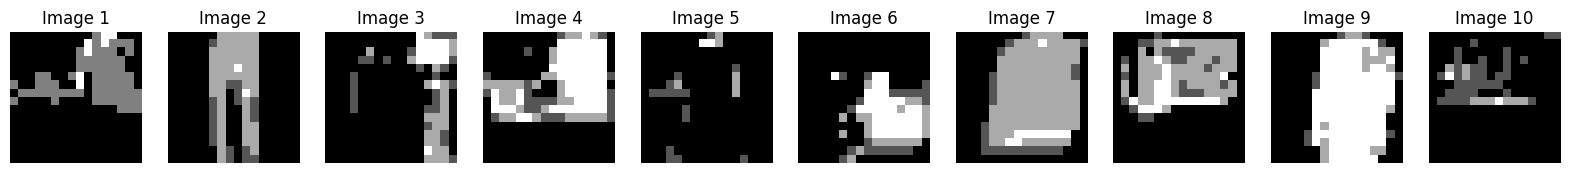

469/469 [==============================] - 31s 67ms/step - loss: 0.3261
Epoch 114/150
469/469 [==============================] - ETA: 0s - loss: 0.3260

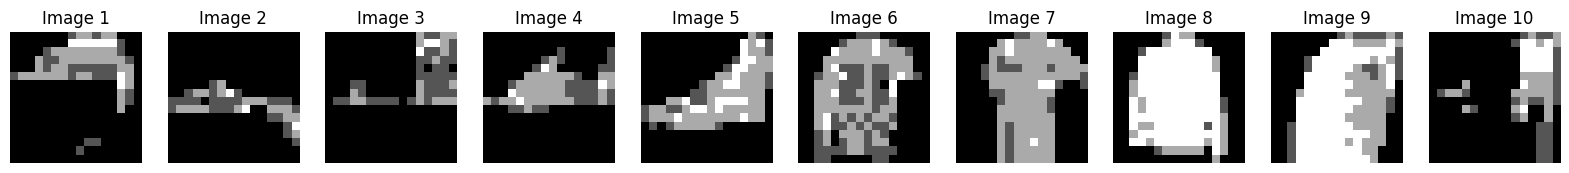

469/469 [==============================] - 32s 69ms/step - loss: 0.3260
Epoch 115/150
469/469 [==============================] - ETA: 0s - loss: 0.3260

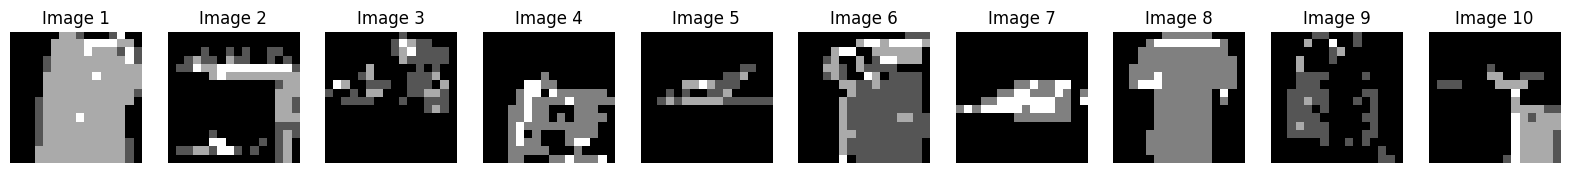

469/469 [==============================] - 31s 67ms/step - loss: 0.3260
Epoch 116/150
469/469 [==============================] - ETA: 0s - loss: 0.3259

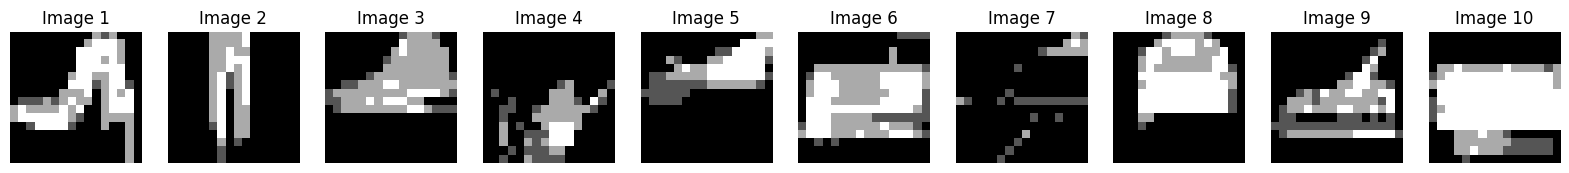

469/469 [==============================] - 33s 71ms/step - loss: 0.3259
Epoch 117/150
469/469 [==============================] - ETA: 0s - loss: 0.3258

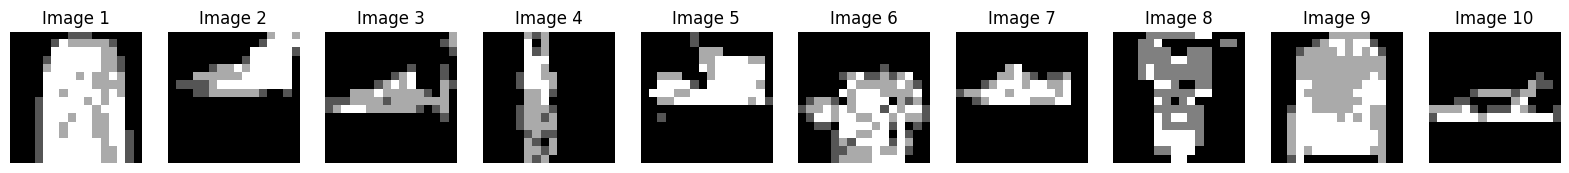

469/469 [==============================] - 31s 66ms/step - loss: 0.3258
Epoch 118/150
469/469 [==============================] - ETA: 0s - loss: 0.3256

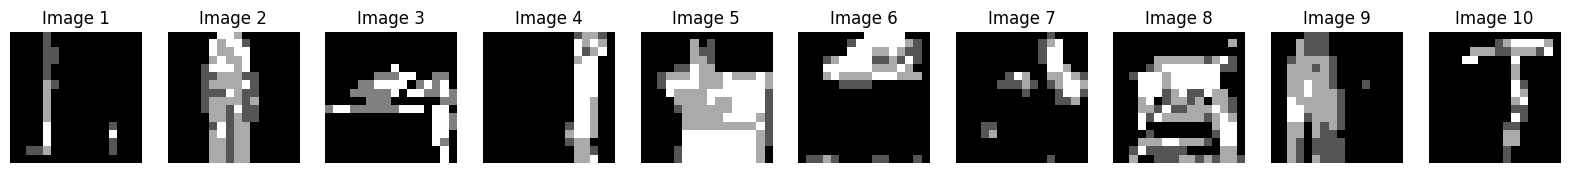

469/469 [==============================] - 32s 68ms/step - loss: 0.3256
Epoch 119/150
469/469 [==============================] - ETA: 0s - loss: 0.3255

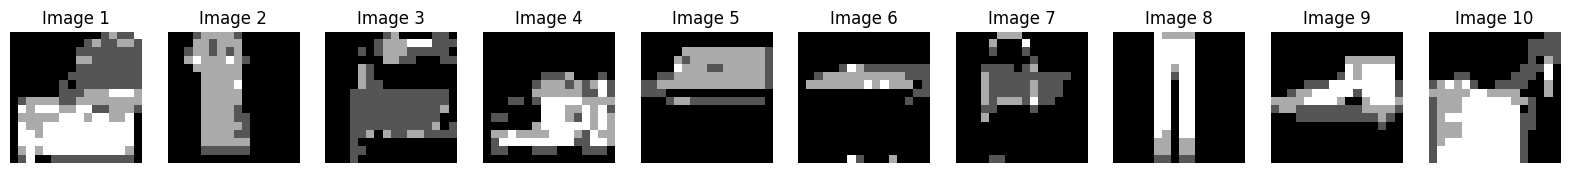

469/469 [==============================] - 31s 67ms/step - loss: 0.3255
Epoch 120/150
469/469 [==============================] - ETA: 0s - loss: 0.3255

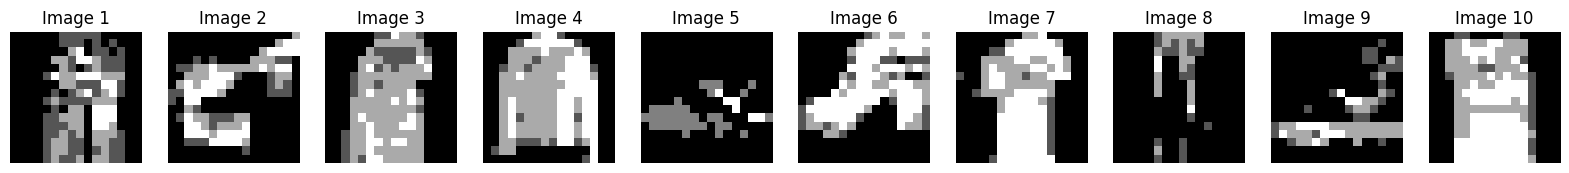

469/469 [==============================] - 31s 66ms/step - loss: 0.3255
Epoch 121/150
467/469 [============================>.] - ETA: 0s - loss: 0.3254

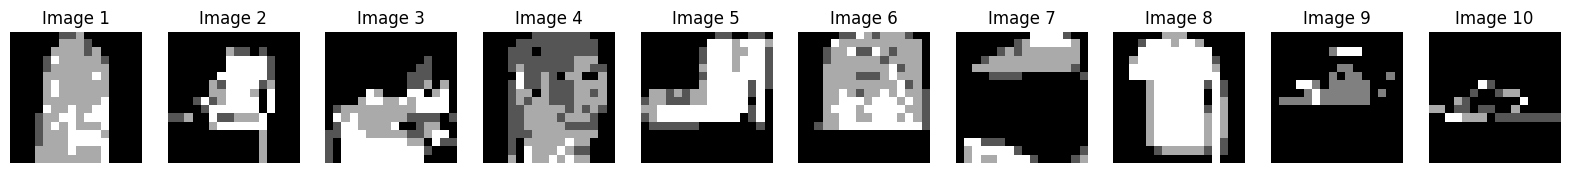

469/469 [==============================] - 32s 69ms/step - loss: 0.3254
Epoch 122/150
469/469 [==============================] - ETA: 0s - loss: 0.3252

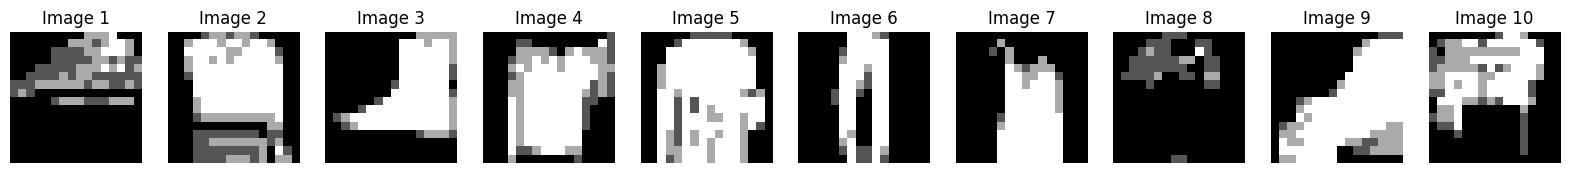

469/469 [==============================] - 31s 66ms/step - loss: 0.3252
Epoch 123/150
469/469 [==============================] - ETA: 0s - loss: 0.3252

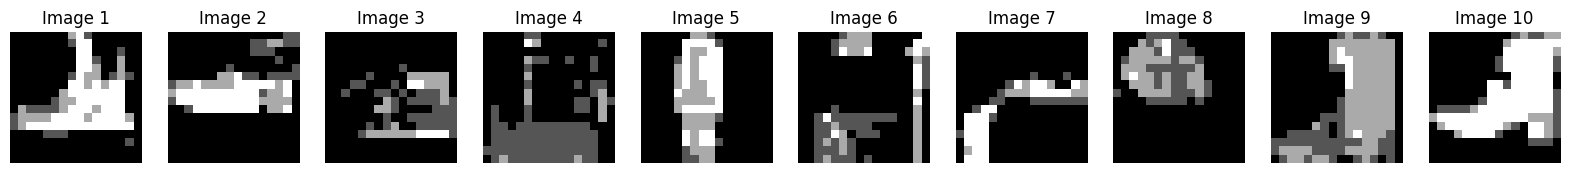

469/469 [==============================] - 33s 71ms/step - loss: 0.3252
Epoch 124/150
469/469 [==============================] - ETA: 0s - loss: 0.3252

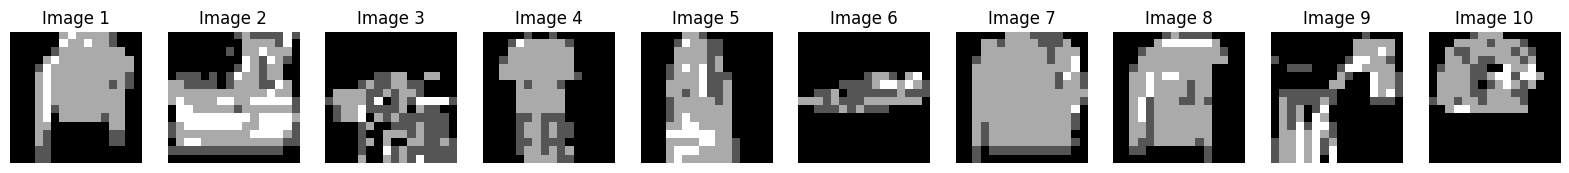

469/469 [==============================] - 31s 66ms/step - loss: 0.3252
Epoch 125/150
469/469 [==============================] - ETA: 0s - loss: 0.3251

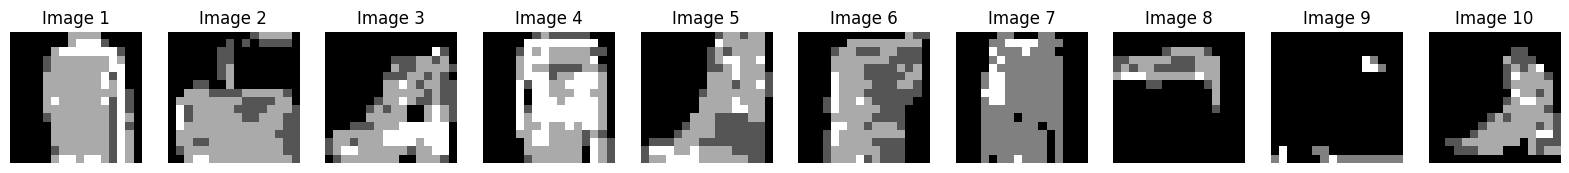

469/469 [==============================] - 31s 67ms/step - loss: 0.3251
Epoch 126/150
469/469 [==============================] - ETA: 0s - loss: 0.3250

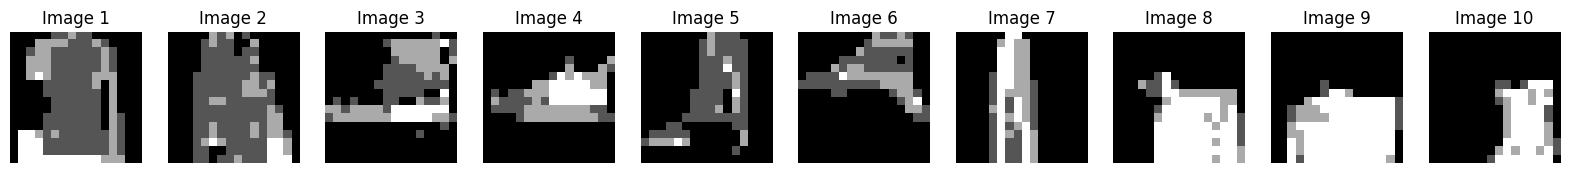

469/469 [==============================] - 32s 68ms/step - loss: 0.3250
Epoch 127/150
469/469 [==============================] - ETA: 0s - loss: 0.3249

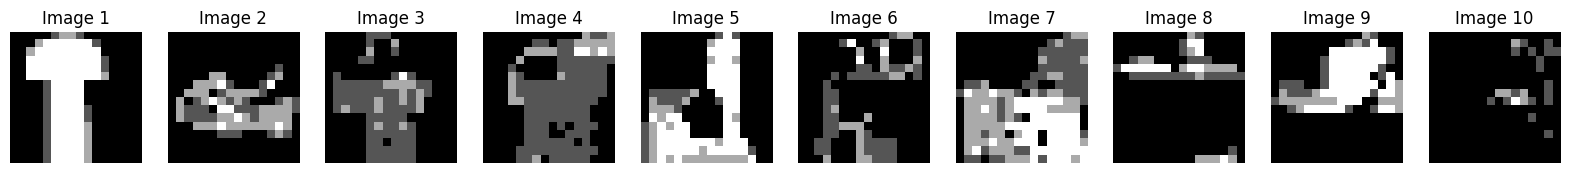

469/469 [==============================] - 31s 66ms/step - loss: 0.3249
Epoch 128/150
469/469 [==============================] - ETA: 0s - loss: 0.3247

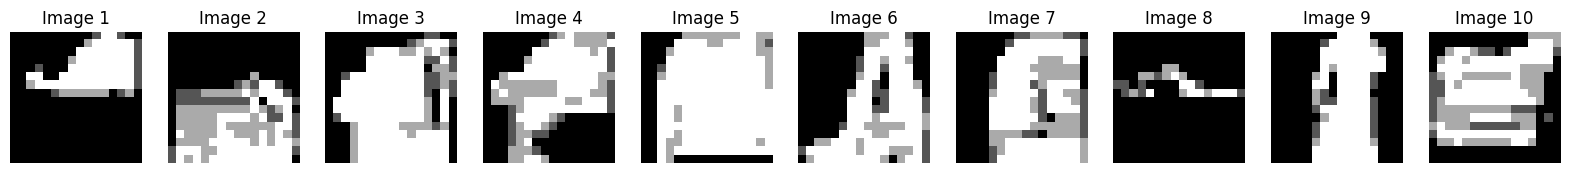

469/469 [==============================] - 33s 70ms/step - loss: 0.3247
Epoch 129/150
469/469 [==============================] - ETA: 0s - loss: 0.3250

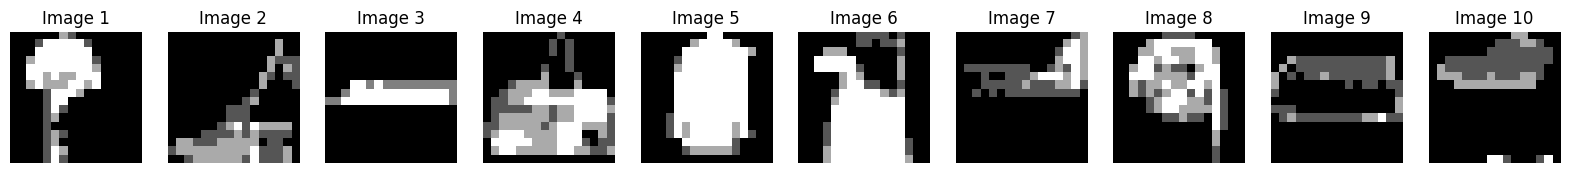

469/469 [==============================] - 32s 68ms/step - loss: 0.3250
Epoch 130/150
469/469 [==============================] - ETA: 0s - loss: 0.3246

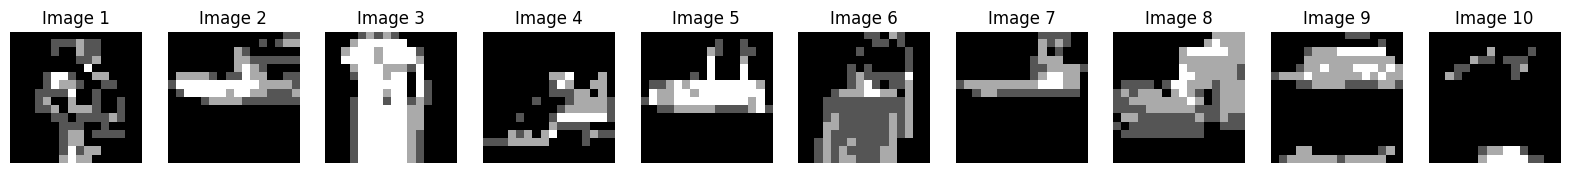

469/469 [==============================] - 34s 72ms/step - loss: 0.3246
Epoch 131/150
469/469 [==============================] - ETA: 0s - loss: 0.3247

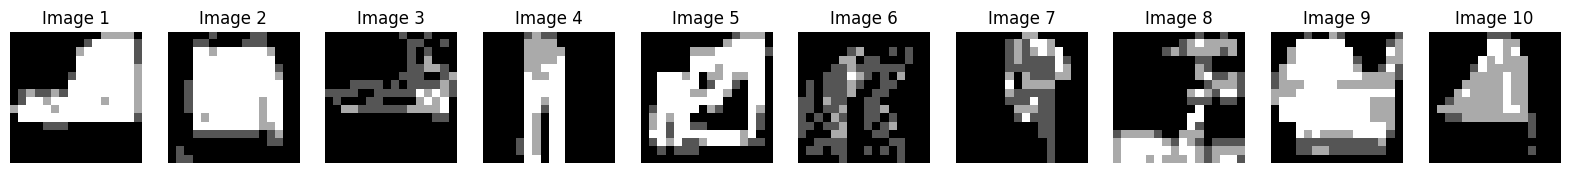

469/469 [==============================] - 32s 68ms/step - loss: 0.3247
Epoch 132/150
467/469 [============================>.] - ETA: 0s - loss: 0.3245

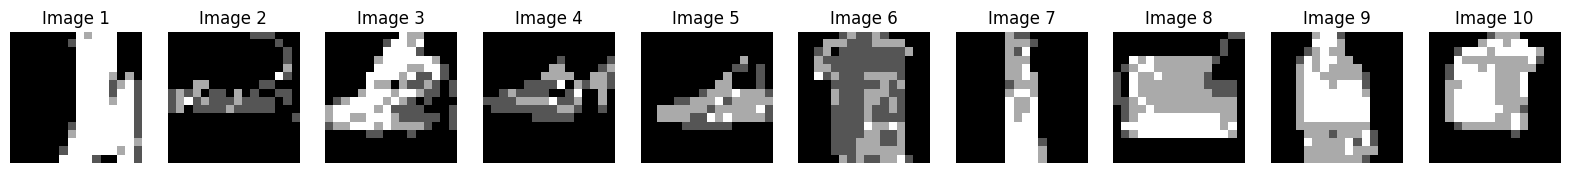

469/469 [==============================] - 32s 69ms/step - loss: 0.3245
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.3245

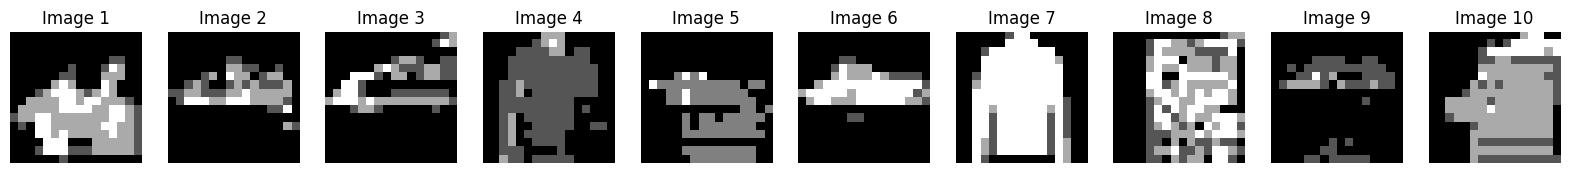

469/469 [==============================] - 32s 68ms/step - loss: 0.3245
Epoch 134/150
469/469 [==============================] - ETA: 0s - loss: 0.3244

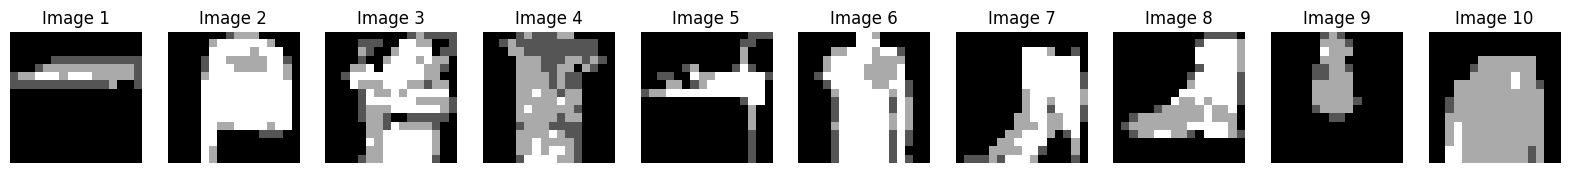

469/469 [==============================] - 32s 68ms/step - loss: 0.3244
Epoch 135/150
469/469 [==============================] - ETA: 0s - loss: 0.3244

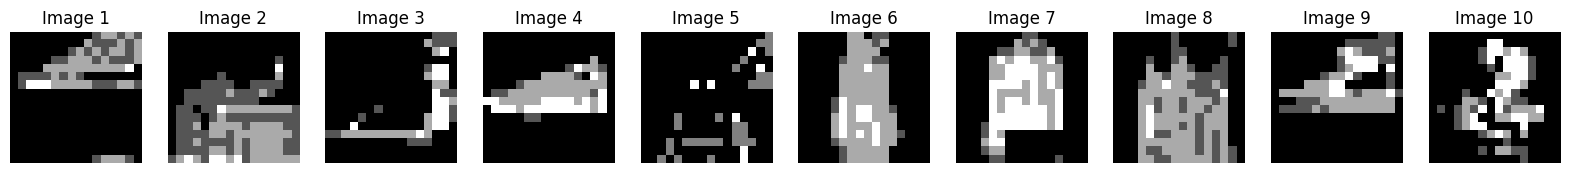

469/469 [==============================] - 34s 72ms/step - loss: 0.3244
Epoch 136/150
469/469 [==============================] - ETA: 0s - loss: 0.3244

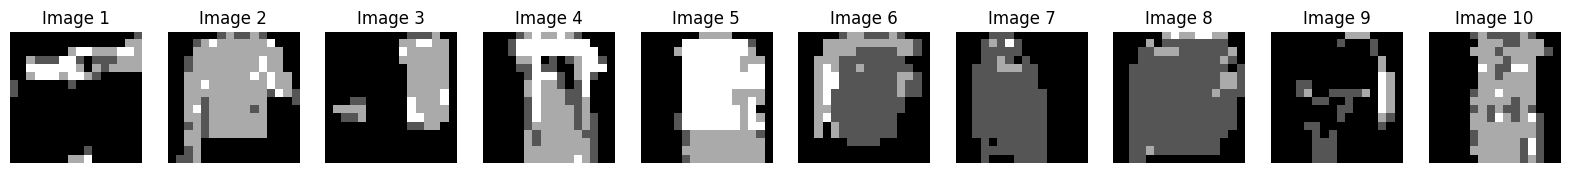

469/469 [==============================] - 31s 66ms/step - loss: 0.3244
Epoch 137/150
469/469 [==============================] - ETA: 0s - loss: 0.3243

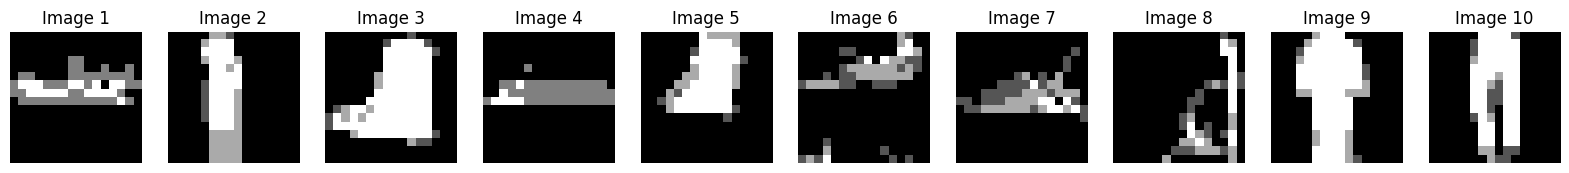

469/469 [==============================] - 34s 73ms/step - loss: 0.3243
Epoch 138/150
469/469 [==============================] - ETA: 0s - loss: 0.3241

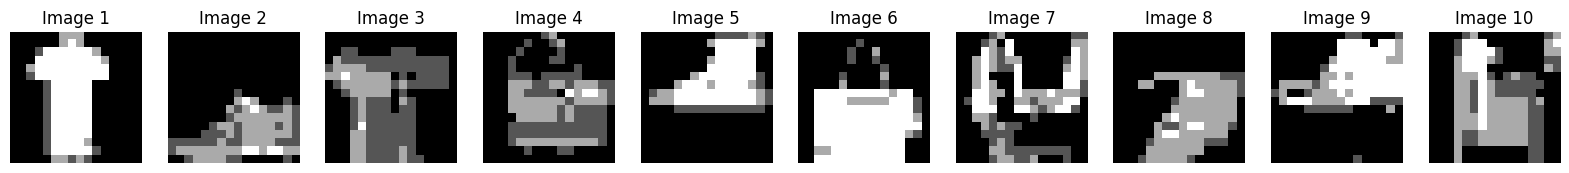

469/469 [==============================] - 32s 68ms/step - loss: 0.3241
Epoch 139/150
467/469 [============================>.] - ETA: 0s - loss: 0.3241

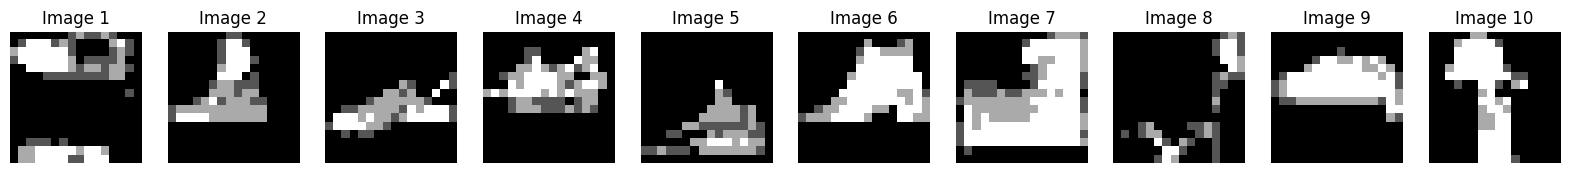

469/469 [==============================] - 32s 68ms/step - loss: 0.3241
Epoch 140/150
469/469 [==============================] - ETA: 0s - loss: 0.3239

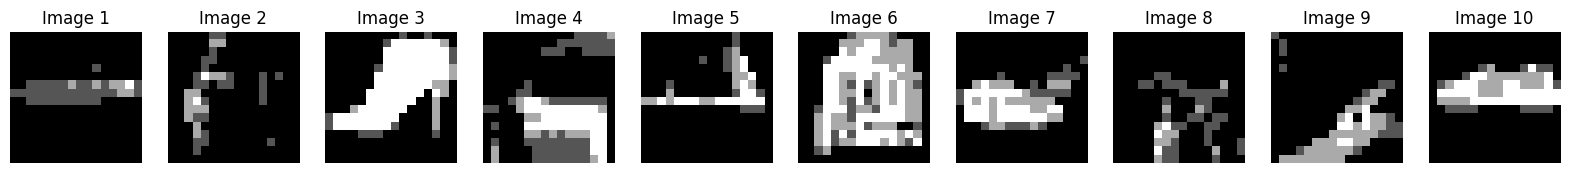

469/469 [==============================] - 33s 70ms/step - loss: 0.3239
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.3239

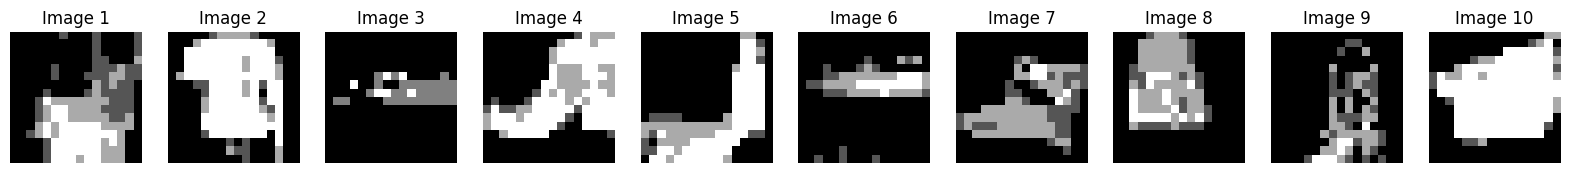

469/469 [==============================] - 31s 66ms/step - loss: 0.3239
Epoch 142/150
469/469 [==============================] - ETA: 0s - loss: 0.3237

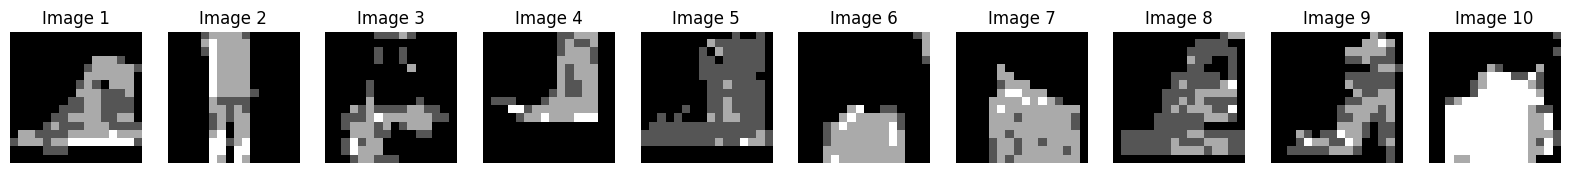

469/469 [==============================] - 32s 69ms/step - loss: 0.3237
Epoch 143/150
469/469 [==============================] - ETA: 0s - loss: 0.3237

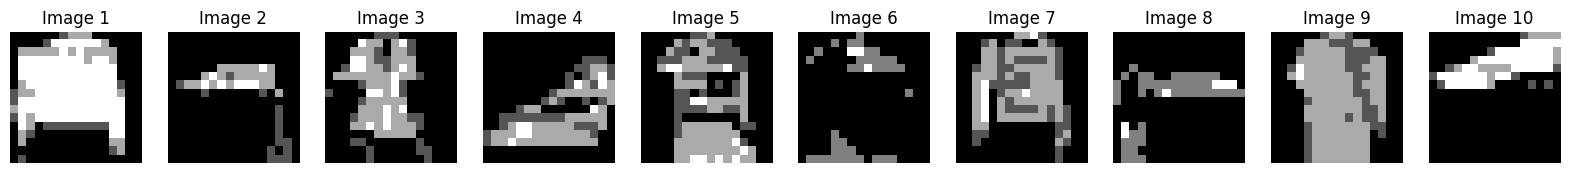

469/469 [==============================] - 32s 68ms/step - loss: 0.3237
Epoch 144/150
469/469 [==============================] - ETA: 0s - loss: 0.3239

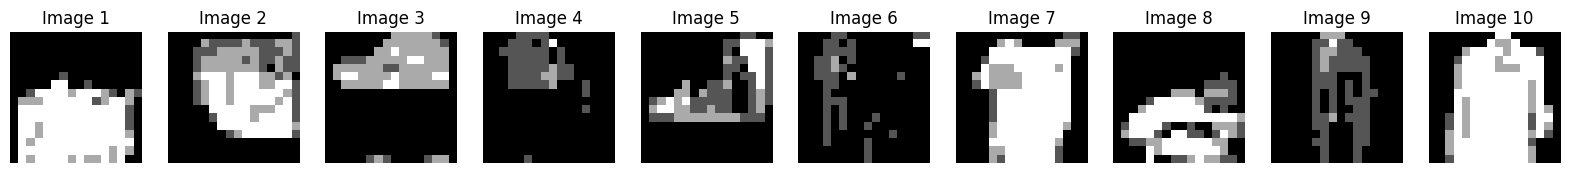

469/469 [==============================] - 33s 71ms/step - loss: 0.3239
Epoch 145/150
469/469 [==============================] - ETA: 0s - loss: 0.3237

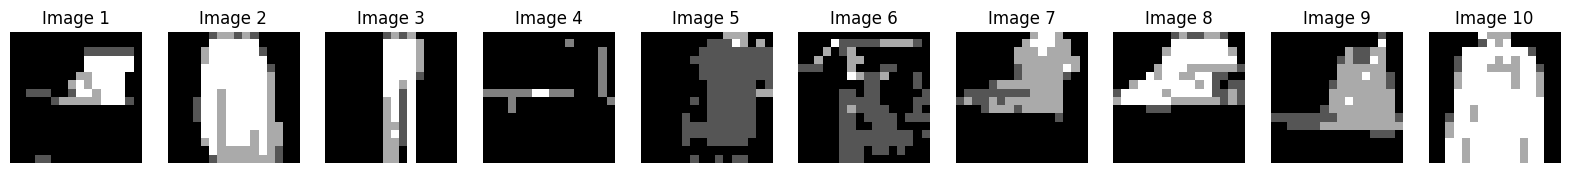

469/469 [==============================] - 30s 65ms/step - loss: 0.3237
Epoch 146/150
469/469 [==============================] - ETA: 0s - loss: 0.3237

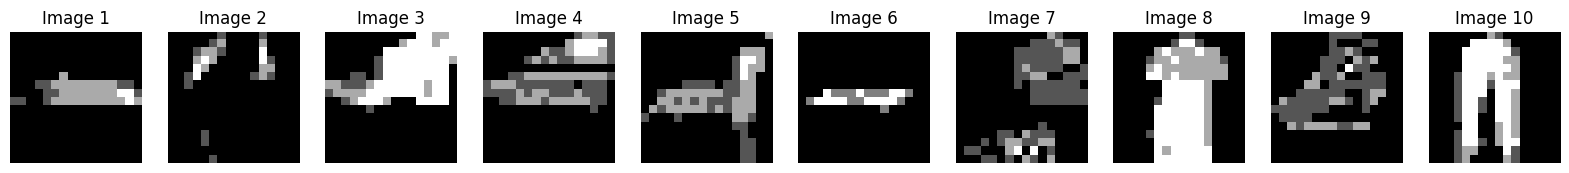

469/469 [==============================] - 32s 67ms/step - loss: 0.3237
Epoch 147/150
469/469 [==============================] - ETA: 0s - loss: 0.3234

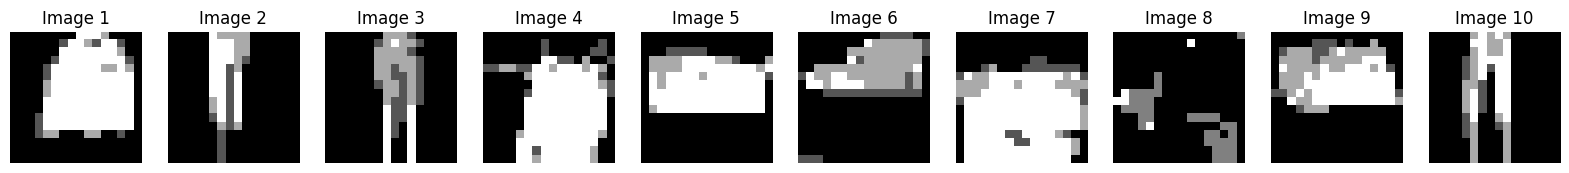

469/469 [==============================] - 33s 69ms/step - loss: 0.3234
Epoch 148/150
469/469 [==============================] - ETA: 0s - loss: 0.3236

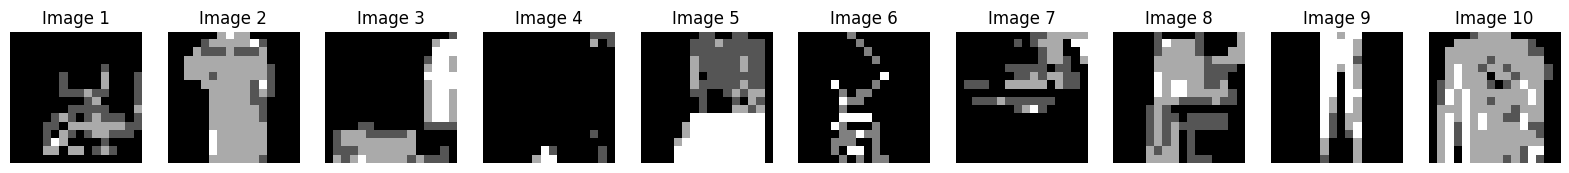

469/469 [==============================] - 31s 65ms/step - loss: 0.3236
Epoch 149/150
469/469 [==============================] - ETA: 0s - loss: 0.3234

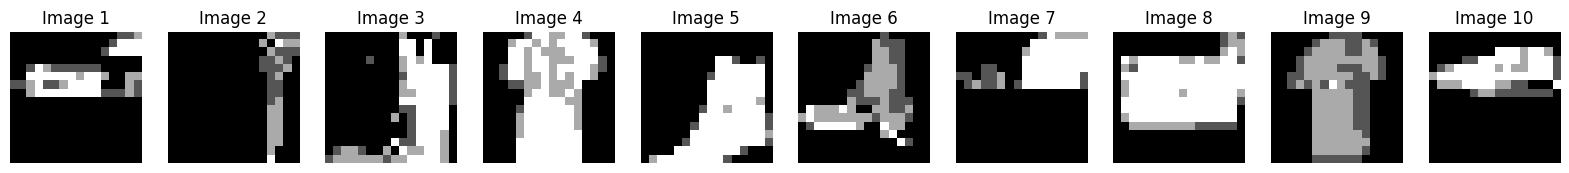

469/469 [==============================] - 32s 69ms/step - loss: 0.3234
Epoch 150/150
467/469 [============================>.] - ETA: 0s - loss: 0.3234

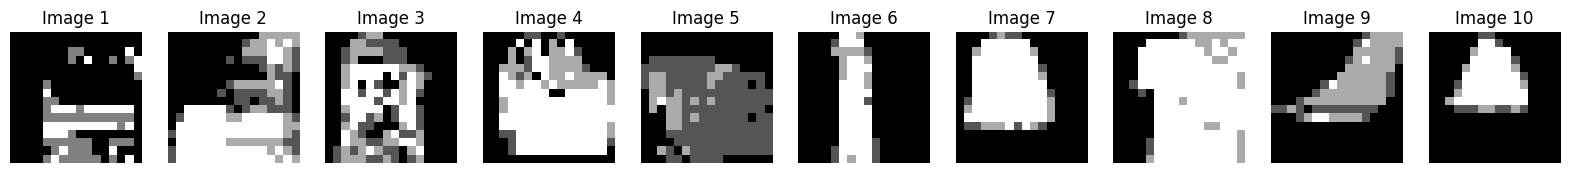

469/469 [==============================] - 30s 65ms/step - loss: 0.3234


In [13]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[img_generator_callback],
)

To generate new images, we need to ask the model to pre
dict the next pixel given all preceding pixels, one pixel at a time. This is a very slow
process compared to a model such as a variational autoencoder! For a 32 × 32 grayscale image, we need to make 1,024 predictions sequentially using the model,
compared to the single prediction that we need to make for a VAE.

This is one of the
major downsides to autoregressive models such as a PixelCNN—they are slow to
sample from, because of the sequential nature of the sampling process.

For this reason, we use an image size of 16 × 16, rather than 32 × 32, to speed up the
generation of new images.

In [14]:
generated_images = img_generator_callback.generate(temperature=1.0)

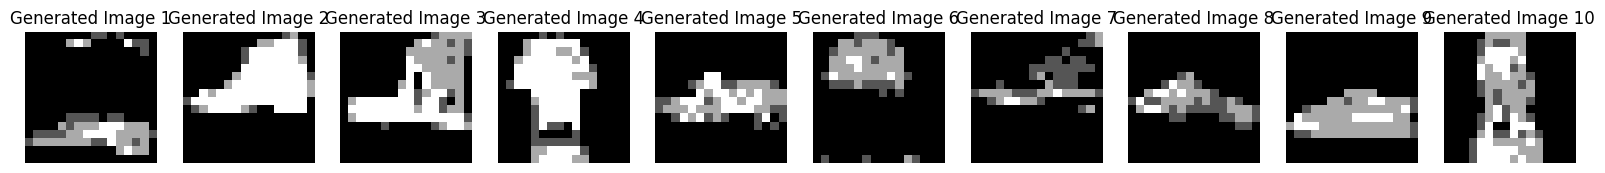

In [15]:
# Plot the generated images
num_img = generated_images.shape[0]
fig, axes = plt.subplots(1, num_img, figsize=(20, 4))

# Plot each generated image
for i in range(num_img):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Generated Image {i+1}')

plt.show()

The model does a great job of re-creating the overall shape and style of the original
images! It is quite amazing that we can treat images as a series of tokens (pixel values)
and apply autoregressive models such as a PixelCNN to produce realistic samples.